
# phyto bloom dynamics from floats
# v3: adapt plots for final figure in the paper

# Fig. 9 in GMD paper


In [1]:

import sys
sys.path.append('/global/homes/c/cnissen/scripts/seawater-3.3.4/seawater/')
import os
import numpy as np
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm
import seawater
#from seawater import dist
#import seawater as sw
import matplotlib.path as mpath
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import random
from numba import njit
from math import sin, cos, sqrt, atan2, radians
from netCDF4 import Dataset
from random import randrange
from tqdm import tqdm
from mpasview import * # Qing's library, modified by Yohei Takano, Dec, 2022
import copy


In [2]:
#-----
# saving plots
#-----

savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/phyto_dynamics_subsampling/6year_run_v2/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)
    

In [3]:
####
# specifics for trajectory output
####

rad_to_deg = 180.0/np.pi
latlim = -45.0

path_mesh = '/global/cfs/cdirs/m4003/maltrud/'
meshID = 'EC30to60E2r2'
meshfile = xr. open_dataset(path_mesh+'ocean.'+meshID+'.210210.nc')
#print(meshfile)

lon  = meshfile['lonCell'].values*rad_to_deg
lat  = meshfile['latCell'].values*rad_to_deg
topo = meshfile['bottomDepth'].values
area = meshfile['areaCell'].values
zlevs            = meshfile['refBottomDepth'].values
layerThickness   = meshfile['layerThickness'].values
restingThickness = meshfile['restingThickness'].values

print(len(lon),'nodes in mesh')
print(topo.shape)
print(area.shape)
print('Min/Max lon:',np.min(lon),np.max(lon))
print('Min/Max lat:',np.min(lat),np.max(lat))
print('layerThickness.shape:',layerThickness.shape)
print('restingThickness.shape:',restingThickness.shape)

meshfile.close()


236853 nodes in mesh
(236853,)
(236853,)
Min/Max lon: 0.0007300572350528742 359.997672445938
Min/Max lat: -78.53259417674468 89.94461290099375
layerThickness.shape: (1, 236853, 60)
restingThickness.shape: (236853, 60)


In [4]:
# for "area": indices of native mesh in focus region
ind_reg = np.where((lat>15.0) & (lat<=30.0) & (lon>190.0) & (lon<=240.0))[0]
print(ind_reg)

target = 8400

global_target = np.sum(area)/1e12/target

num_floats_reduced = int(np.round(np.sum(area[ind_reg])/1e12/global_target)) 

print(num_floats_reduced)


[    33     53   1857 ... 235537 236449 236851]
198


In [5]:
#----
# load mask of biomes
#----

path_mask = '/global/cfs/cdirs/m4003/cnissen/masks/'
file_mask = 'reccap_mask_regions_e3sm_mesh_EC30to60E2r2_wSubregions.nc'

ff = xr. open_dataset(path_mask+file_mask)
mask_global=ff['mask_e3sm_all_regions'].values.squeeze()
ff.close()

#subareas = ['Atlantic','Pacific','Indian','Arctic','SouthernOcean']
#subareas = ['Atlantic','Pacific','Indian','Arctic','STSS','SPSS','ICE']

print('Min/Max mask_e3sm_all_regions:',np.min(mask_global),np.max(mask_global)) 

print(mask_global.shape,lat.shape,lon.shape)


Min/Max mask_e3sm_all_regions: 0.0 27.0
(236853,) (236853,) (236853,)


In [6]:
#---
# FUNCTION
#---

#@njit
def get_temporal_avg(data_reg,data,area,num_time,num_depth,subregions,subregions_all,mask_global,lat,lon):
    for dd in range(0,num_depth):
        for ss in range(0,len(subregions)):
            if subregions[ss] in ['subtr_NE_pacific']:
                ind_reg = np.where((lat>15.0) & (lat<=30.0) & (lon>190.0) & (lon<=240.0))[0]
            else:
                ss_all = subregions_all.index(subregions[ss])
                ind_reg = np.where(mask_global==ss_all+1)[0]
            for tt in range(0,num_time):
                data_reg[dd,ss,tt] = np.nansum(data[tt,ind_reg,dd]*area[ind_reg])/np.sum(area[ind_reg])
    return data_reg
                

In [7]:
#-----
# load full model output
#-----

path1 = '/global/cfs/cdirs/m4003/maltrud/6year/dailyEulerianAverages/'

months = ['01','02','03','04','05','06','07','08','09','10','11','12']

# all available regions in mask file -> pay attention to indices if only selecting a subset!!
subregions_all = ['NA SPSS','NA STSS','NA STPS','AEQU','SA STPS','MED','IND STPS','xx',\
                 'NP SPSS','NP STSS','NP STPS','PEQU-W','PEQU-E','SP STPS',\
                 'ARCTIC ICE','NP ICE','NA ICE','Barents',\
                 'STSS_Atl','SPSS_Atl','ICE_Atl','STSS_Ind','SPSS_Ind',\
                 'ICE_Ind','STSS_Pac','SPSS_Pac','ICE_Pac']

# FOR these regions, the txt files have been created
#subregions = ['NA SPSS','NA STSS','NA STPS','AEQU','SA STPS',\
#             'NP SPSS','NP STSS','NP STPS','PEQU-W','PEQU-E','SP STPS',\
#             'STSS_Atl','SPSS_Atl','STSS_Ind','SPSS_Ind','STSS_Pac','SPSS_Pac','IND STPS']

#subregions = ['NP STPS']
subregions = ['subtr_NE_pacific']


year_list = ['0055','0056','0057','0058','0059','0060']

#"1.NA SPSS, 2.NA STSS, 3.NA STPS, 4.AEQU, 5.SA STPS, 6.MED (not in FM14)" ;
#"7.IND STPS, 8.(not in FM14)" ;
#"9.NP SPSS, 10.NP STSS, 11.NP STPS, 12.PEQU-W, 13.PEQU-E, 14.SP STPS" ;
#"15.ARCTIC ICE (not in FM14), 16.NP ICE, 17.NA ICE, 18.Barents (not in FM14)" ;
#"19. STSS_Atl, 20. SPSS_Atl, 21. ICE_Atl, 22. STSS_Ind, 23. SPSS_Ind, 
# 24. ICE_Ind, 25. STSS_Pac, 26. SPSS_Pac, 27. ICE_Pac"

savep1 = '/pscratch/sd/c/cnissen/E3SM_txt_files/phyto_seasonality/'

#---
# save phenology as txt file
#---
# ONLY NEEDS TO BE DONE ONCE!
load_data_save_phenology = False
if load_data_save_phenology:
    for yy in tqdm(range(0,len(year_list))):
        which_year = year_list[yy]
        for mm in range(0,len(months)):
            print('Load month',months[mm])

            file1 = 'GMPAS-OIECO-JRA_r05_EC30to60E2r2_floats_chrys01.mpaso.hist.am.timeSeriesStatsDaily.'+\
                which_year+'-'+months[mm]+'-01.Biomass.nc'

            ff = xr. open_dataset(path1+file1)
            data1=ff['timeDaily_avg_ecosysTracers_diatC'].values.squeeze()
            data2=ff['timeDaily_avg_ecosysTracers_diazC'].values.squeeze()
            data3=ff['timeDaily_avg_ecosysTracers_spC'].values.squeeze()
            ff.close()

            data = data1 + data2 + data3
            #print(data.shape)
            del data1,data2,data3
            data = np.ma.masked_where(data<0,data)

            num_depth = data.shape[2]
            num_time  = data.shape[0]

            data_reg = np.zeros([data.shape[2],len(subregions),data.shape[0]]) 
            data_reg = get_temporal_avg(data_reg,data,area,num_time,num_depth,\
                                        subregions,subregions_all,mask_global,lat,lon)

            for dd in range(0,data.shape[2]):
                for ss in range(0,len(subregions)):
                    # write 1 file per year per subregion per depth
                    # i.e., first month: create the file, 2nd month: append to file
                    if mm==0: # create new file
                        np.savetxt(savep1+'Phyto_C_'+subregions[ss].replace(' ','_')+\
                                   '_year'+which_year+'_zlev'+str(dd)+'.txt', data_reg[dd,ss,:])
                    else: # append
                        with open(savep1+'Phyto_C_'+subregions[ss].replace(' ','_')+\
                                   '_year'+which_year+'_zlev'+str(dd)+'.txt', "ab") as f:
                            np.savetxt(f, data_reg[dd,ss,:])

            del data_reg,num_time,num_depth,data,file1
else:
    # load data from txt files!
    data_all = np.zeros([2190,len(zlevs)])
    for dd in range(0,len(zlevs)):
        for yy in range(0,len(year_list)):
            which_year = year_list[yy]
            for ss in range(0,len(subregions)):
                aux = np.loadtxt(savep1+'Phyto_C_'+subregions[ss].replace(' ','_')+\
                            '_year'+which_year+'_zlev'+str(dd)+'.txt',\
                                  delimiter="\n", unpack=False) 
                if yy==0:
                    data = aux
                else:
                    data = np.hstack((data,aux)) # vstack gives  years x days; hstack gives all in one vector
                del aux
        data_all[:,dd] = data
        del data
    # 10-daily
    data_all10 = data_all[0::10]

                #with open(savep1+'Phyto_C_'+subregions[ss].replace(' ','_')+\
                #            '_year'+which_year+'_zlev'+str(dd)+'.txt') as f:
                #    data = f.readlines()

## vertically integrate
#dz_3D_full = np.tile(dz,[data.shape[0],data.shape[1],1])
#data_int = np.nansum(np.multiply(data,dz_3D_full),axis=2)
#print(data_int.shape)
print('done')


done


In [40]:
print(data_all.shape)

(2190, 60)


In [43]:
#---
# FUNCTION
#---

def get_all_6_bloom_peaks(data):
    # provide 10-daily data for 6 years -> 219 entries
    # get magnitude and timing of bloom
    
    bloom_peak = np.zeros(6)
    bloom_peak[0] = np.max(data[0:37])
    bloom_peak[1] = np.max(data[37:73])
    bloom_peak[2] = np.max(data[73:110])
    bloom_peak[3] = np.max(data[110:146])
    bloom_peak[4] = np.max(data[146:183])
    bloom_peak[5] = np.max(data[183:])
    
    bloom_time = np.zeros(6)
    bloom_time[0] = np.argmax(data[0:37])
    bloom_time[1] = np.argmax(data[37:73])
    bloom_time[2] = np.argmax(data[73:110])
    bloom_time[3] = np.argmax(data[110:146])
    bloom_time[4] = np.argmax(data[146:183])
    bloom_time[5] = np.argmax(data[183:])
    
    return bloom_peak,bloom_time


def get_all_6_bloom_peaks_daily_input(data_daily):
    # provide daily data for 6 years -> 2190 entries (6 x 365)
    # get magnitude and timing of bloom
    
    bloom_peak = np.zeros(6)
    bloom_peak[0] = np.max(data_daily[0:365])
    bloom_peak[1] = np.max(data_daily[365:2*365])
    bloom_peak[2] = np.max(data_daily[2*365:3*365])
    bloom_peak[3] = np.max(data_daily[3*365:4*365])
    bloom_peak[4] = np.max(data_daily[4*365:5*365])
    bloom_peak[5] = np.max(data_daily[5*365:])
    
    bloom_time = np.zeros(6)
    bloom_time[0] = np.argmax(data_daily[0:365])
    bloom_time[1] = np.argmax(data_daily[365:2*365])
    bloom_time[2] = np.argmax(data_daily[2*365:3*365])
    bloom_time[3] = np.argmax(data_daily[3*365:4*365])
    bloom_time[4] = np.argmax(data_daily[4*365:5*365])
    bloom_time[5] = np.argmax(data_daily[5*365:])
    
    return bloom_peak,bloom_time


(219, 60)
(2190, 60)
30.0 60.0

30m, 10-daily
0.7157406508012236 7
1.1487130009223812 6
0.8109659218246953 8
0.9554655046918825 7
0.9430426231322362 8
0.9284029411761835 3

60m, 10-daily
0.5917008697041065 12
0.6265681320017832 13
0.6196733211888729 17
0.6297355522174786 16
0.5889882165777582 14
0.5978716039257119 21

30m, daily
magnitude, timing, ratio daily/10-daily, diff. timing daily vs 10-daily: 0.7870995908781258 74 1.099699437215171 4
magnitude, timing, ratio daily/10-daily, diff. timing daily vs 10-daily: 1.1742874361315823 66 1.0222635551166093 6
magnitude, timing, ratio daily/10-daily, diff. timing daily vs 10-daily: 0.8965689109412786 54 1.1055568265112474 -26
magnitude, timing, ratio daily/10-daily, diff. timing daily vs 10-daily: 0.9797618907862219 77 1.025428846959969 7
magnitude, timing, ratio daily/10-daily, diff. timing daily vs 10-daily: 1.0567092469423587 57 1.1205317989048984 -23
magnitude, timing, ratio daily/10-daily, diff. timing daily vs 10-daily: 0.928402941176

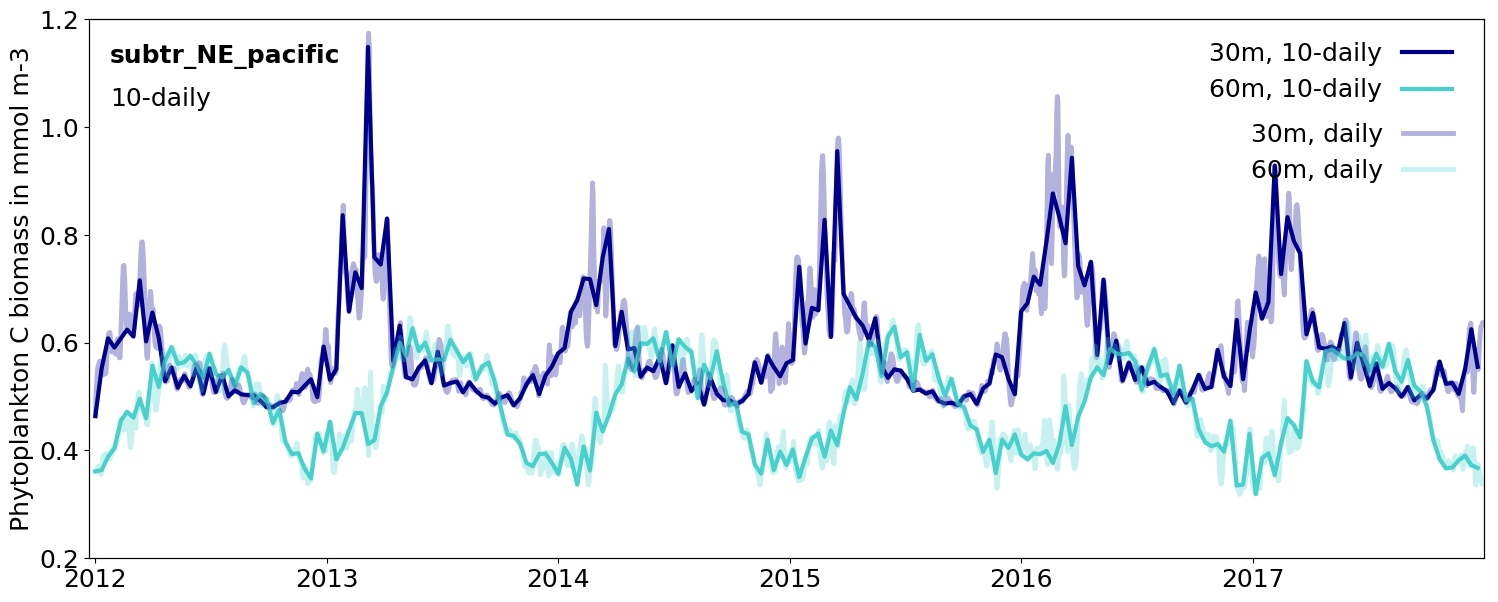

In [47]:
#---
# plot time series
#---

print(data_all10.shape)
print(data_all.shape)
#print(data)


dd_list = [2,5] 
#dd_list = [3,7,11]
print(zlevs[dd_list[0]],zlevs[dd_list[1]])

print('')
print('30m, 10-daily')
dd=0
bloom_peak_euler1,bloom_time_euler1 = get_all_6_bloom_peaks(data_all10[:,dd_list[dd]])
for ii in range(0,6):
    print(bloom_peak_euler1[ii],int(bloom_time_euler1[ii]))
    
print('')
print('60m, 10-daily')
dd=1
bloom_peak_euler2,bloom_time_euler2 = get_all_6_bloom_peaks(data_all10[:,dd_list[dd]])
for ii in range(0,6):
    print(bloom_peak_euler2[ii],int(bloom_time_euler2[ii]))
    
    
print('')
print('30m, daily')
dd=0
bloom_peak_euler1_daily,bloom_time_euler1_daily = get_all_6_bloom_peaks_daily_input(data_all[:,dd_list[dd]])
for ii in range(0,6):
    print('magnitude, timing, ratio daily/10-daily, diff. timing daily vs 10-daily:',\
          bloom_peak_euler1_daily[ii],int(bloom_time_euler1_daily[ii]),\
          bloom_peak_euler1_daily[ii]/bloom_peak_euler1[ii],int(bloom_time_euler1_daily[ii])-10*int(bloom_time_euler1[ii]))
    
print('')
print('60m, daily')
dd=1
bloom_peak_euler2_daily,bloom_time_euler2_daily = get_all_6_bloom_peaks_daily_input(data_all[:,dd_list[dd]])
for ii in range(0,6):
    print('magnitude, timing, ratio daily/10-daily, diff. timing daily vs 10-daily:',\
          bloom_peak_euler2_daily[ii],int(bloom_time_euler2_daily[ii]),\
          bloom_peak_euler2_daily[ii]/bloom_peak_euler2[ii],int(bloom_time_euler2_daily[ii])-10*int(bloom_time_euler2[ii]))
    
    
color1 = 'darkblue'
color2 = 'mediumturquoise'
color3 = 'cornflowerblue'
color4 = 'mediumpurple'
lw = 3
fs = 18
alpha1=0.3

#fig = plt.figure(figsize=(18,7))

fig, ax1 = plt.subplots(figsize=(18,7))
ax2 = ax1.twinx()

ax1.plot(range(0,len(data_all10[:,dd_list[0]])),data_all10[:,dd_list[0]],\
         color=color1,linewidth=lw,label=str(int(zlevs[dd_list[0]]))+'m, 10-daily')
ax1.plot(range(0,len(data_all10[:,dd_list[1]])),data_all10[:,dd_list[1]],\
         color=color2,linewidth=lw,label=str(int(zlevs[dd_list[1]]))+'m, 10-daily')
ax1.set_xticks(np.arange(0,219,36.5))
ax1.set_xticklabels([])
ax1.set_yticks([0.2,0.4,0.6,0.8,1.0,1.2])
ax1.set_yticklabels([0.2,0.4,0.6,0.8,1.0,1.2])
ax1.set_ylabel('Phytoplankton C biomass in mmol m-3',fontsize=fs)
ax1.set_xlim((-1,219))
ax1.set_ylim((0.2,1.2))
ax1.annotate('10-daily',xy=(0.015,0.84),\
                xycoords='axes fraction',fontsize=fs,ha='left',color='k')

ax1.annotate(subregions[0],xy=(0.015,0.92),\
                xycoords='axes fraction',fontsize=fs,ha='left',color='k',fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=fs)
#ax1.legend(frameon=False,prop={'size': 18})
ax1.legend(loc='upper center', bbox_to_anchor=(0.89, 1),\
                   ncol=1,fancybox=True, frameon=False,markerfirst=False,shadow=False,prop={'size': 18})

ax2.plot(np.arange(0,len(data_all10[:,dd_list[0]]),0.1),data_all[:,dd_list[0]],\
         color=color1,linewidth=lw+0.5,alpha=alpha1,zorder=0,label=str(int(zlevs[dd_list[0]]))+'m, daily')
ax2.plot(np.arange(0,len(data_all10[:,dd_list[0]]),0.1),data_all[:,dd_list[1]],\
         color=color2,linewidth=lw+0.5,alpha=alpha1,zorder=0,label=str(int(zlevs[dd_list[1]]))+'m, daily')
ax2.set_xlim((-1,219))
ax2.set_ylim((0.2,1.2))
ax2.tick_params(axis='both', which='major', labelsize=fs)
ax2.set_xticks(np.arange(0,219,36.5))
ax2.set_xticklabels([2012,2013,2014,2015,2016,2017])
ax2.set_yticks([])
ax2.set_yticklabels([])
#ax2.legend(frameon=False,prop={'size': 18})
ax2.legend(loc='upper center', bbox_to_anchor=(0.905, 0.85),\
                   ncol=1,fancybox=True, frameon=False,markerfirst=False,shadow=False,prop={'size': 18})

save_plots = True
if save_plots:
    dpicnt = 150
    filename = 'Phyto_C_at_'+\
                         str(int(zlevs[dd_list[0]]))+'m_2012_2017.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    del filename
    
plt.show()

# make the time series plot nice (mark bloom peak each year for each depth level)
# make maps of a specific day and plot carbon at 40m, 80m, 120m near the focus region
# do subsampling exercise:
#    mismatch in magnitude vs. float density
#    mismatch in timing vs. float density



In [12]:
#---
# first step: plot the maps to make sure I choose the most interesting region!
# load one year (e.g., year 3) and plot map at day of peak-at-40m for all three depths
#  -> look at spatial variability!

which_year = year_list[2]
mm=2
print('Load month',months[mm])

file1 = 'GMPAS-OIECO-JRA_r05_EC30to60E2r2_floats_chrys01.mpaso.hist.am.timeSeriesStatsDaily.'+\
    which_year+'-'+months[mm]+'-01.Biomass.nc'

ff = xr. open_dataset(path1+file1)
data1=ff['timeDaily_avg_ecosysTracers_diatC'].values.squeeze()
data2=ff['timeDaily_avg_ecosysTracers_diazC'].values.squeeze()
data3=ff['timeDaily_avg_ecosysTracers_spC'].values.squeeze()
ff.close()
            
data = data1 + data2 + data3
del data1,data2,data3

tt = 5
data1 = data[tt,:,dd_list[0]]
data2 = data[tt,:,dd_list[1]]

tt = 15
data1b = data[tt,:,dd_list[0]]
data2b = data[tt,:,dd_list[1]]

#data3 = data[tt,:,dd_list[2]]
del data

print(data1.shape,data2.shape)


Load month 03
(236853,) (236853,)


In [13]:
#---
# plot
#---
cmap1 = copy.copy(plt.cm.RdYlBu_r)
cmap1.set_under('w')

# Restart files
meshroot = '/global/cfs/cdirs/m4003/maltrud/' # restart file
meshfile = meshroot+'ocean.EC30to60E2r2.210210.nc' # EC30to60E2r2

# MPAS-O input file (model output)
inputroot = '/global/cfs/cdirs/m4003/maltrud/6year/monthlyEulerianAverages/'
year_list = ['0055','0056','0057','0058','0059','0060']

# MPAS-O mesh for EC30to60E2r2
mpasmesh = MPASMesh(name = 'EC30to60E2r2', filepath = meshfile)
print(mpasmesh)

dpicnt = 200


<class 'mpasview.data.MPASMesh'>:
        name: EC30to60E2r2
      ncells: 236853
      nedges: 719506
   nvertices: 482371
   on sphere: True


axis not defined
Plotting 'Phytoplankton carbon biomass at 30m (mmol m-3)' map in the 'north_pacific' (93442 data points)...
[0.75549775 0.48729023 0.5846214  ... 0.6247927  0.728945   0.6538045 ]
-2.9999999e+34 11.091709
/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/phyto_dynamics_subsampling/6year_run_v2/Phyto_C_at_30m_2014_March_5.png
axis not defined
Plotting 'Phytoplankton carbon biomass at 30m (mmol m-3)' map in the 'north_pacific' (93442 data points)...
[0.75549775 0.48729023 0.5846214  ... 0.6247927  0.728945   0.6538045 ]
-2.9999999e+34 11.091709
/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/phyto_dynamics_subsampling/6year_run_v2/Phyto_C_at_30m_2014_March_5_COLORBAR.png
/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/phyto_dynamics_subsampling/6year_run_v2/Phyto_C_at_30m_2014_March_5_COLORBAR.eps


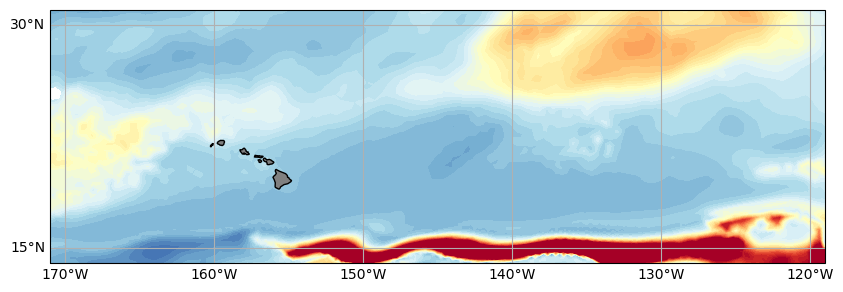

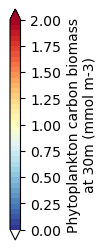

In [14]:
#---
# 1st depth level
#---
save_plots = True
width,height = 10,5 # 15,6; 18,7

res = 0.05
levels = np.arange(0, 2+res, res)

data_plot = np.copy(data1)
data_plot[data_plot==0]        = -999
data_plot[np.isnan(data_plot)] = -999
mpasomap_run1 = MPASOMap(data = data_plot, name = 'Phytoplankton carbon biomass at '+\
                         str(int(zlevs[dd_list[0]]))+'m',\
                         units = 'mmol m-3', mesh = mpasmesh)
plt.figure(figsize=(width,height))
m = mpasomap_run1.plot(region = 'north_pacific', levels = levels, cmap = cmap1, ptype = 'contourf',colorbar=False) # pcolor, contourf
#plt.gca().colorbar.remove()
if save_plots:
    filename = 'Phyto_C_at_'+\
                         str(int(zlevs[dd_list[0]]))+'m_2014_March_5.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    del filename
    
    
plt.figure(figsize=(width,height))
m = mpasomap_run1.plot(region = 'north_pacific', levels = levels, cmap = cmap1, ptype = 'contourf') 
plt.gca().set_visible(False)
if save_plots:
    filename = 'Phyto_C_at_'+\
                         str(int(zlevs[dd_list[0]]))+'m_2014_March_5_COLORBAR.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    filename = 'Phyto_C_at_'+\
                         str(int(zlevs[dd_list[0]]))+'m_2014_March_5_COLORBAR.eps'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    del filename
    

axis not defined
Plotting 'Phytoplankton carbon biomass at 60m (mmol m-3)' map in the 'north_pacific' (93442 data points)...
[0.3549031  0.3728438  0.42850307 ... 0.36528438 0.50914913 0.46665955]
-2.9999999e+34 3.9269753
/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/phyto_dynamics_subsampling/6year_run_v2/Phyto_C_at_60m_2014_March_5.png
axis not defined
Plotting 'Phytoplankton carbon biomass at 60m (mmol m-3)' map in the 'north_pacific' (93442 data points)...
[0.3549031  0.3728438  0.42850307 ... 0.36528438 0.50914913 0.46665955]
-2.9999999e+34 3.9269753
/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/phyto_dynamics_subsampling/6year_run_v2/Phyto_C_at_60m_2014_March_5_COLORBAR.png
/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/phyto_dynamics_subsampling/6year_run_v2/Phyto_C_at_60m_2014_March_5_COLORBAR.eps


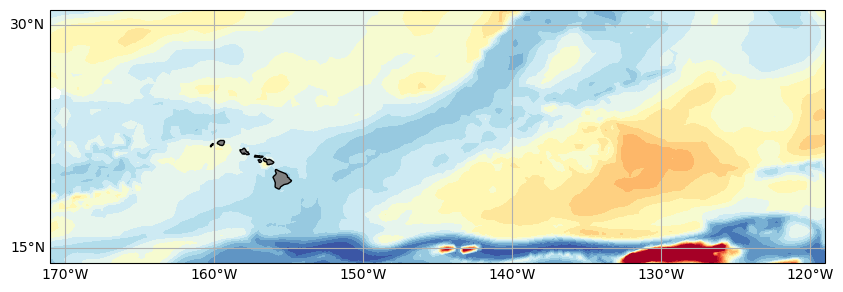

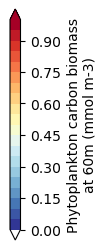

In [15]:
#---
# 2nd depth level
#---
#levels1 = levels/2
res = 0.05
levels = np.arange(0, 1.0+res, res)

data_plot = np.copy(data2)
data_plot[data_plot==0]        = -999
data_plot[np.isnan(data_plot)] = -999
mpasomap_run1 = MPASOMap(data = data_plot, name = 'Phytoplankton carbon biomass at '+\
                         str(int(zlevs[dd_list[1]]))+'m',\
                         units = 'mmol m-3', mesh = mpasmesh)
plt.figure(figsize=(width,height))
m = mpasomap_run1.plot(region = 'north_pacific', levels = levels, cmap = cmap1, ptype = 'contourf',colorbar=False) # pcolor, contourf
if save_plots:
    filename = 'Phyto_C_at_'+\
                         str(int(zlevs[dd_list[1]]))+'m_2014_March_5.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    del filename

plt.figure(figsize=(width,height))
m = mpasomap_run1.plot(region = 'north_pacific', levels = levels, cmap = cmap1, ptype = 'contourf') 
plt.gca().set_visible(False)
if save_plots:
    filename = 'Phyto_C_at_'+\
                         str(int(zlevs[dd_list[1]]))+'m_2014_March_5_COLORBAR.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    filename = 'Phyto_C_at_'+\
                         str(int(zlevs[dd_list[1]]))+'m_2014_March_5_COLORBAR.eps'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    del filename
    

axis not defined
Plotting 'Phytoplankton carbon biomass at 30m (mmol m-3)' map in the 'north_pacific' (93442 data points)...
[1.5787098  0.50719774 0.49809077 ... 0.5644436  0.6862102  0.96355844]
-2.9999999e+34 24.097046
/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/phyto_dynamics_subsampling/6year_run_v2/Phyto_C_at_30m_2014_March_15.png


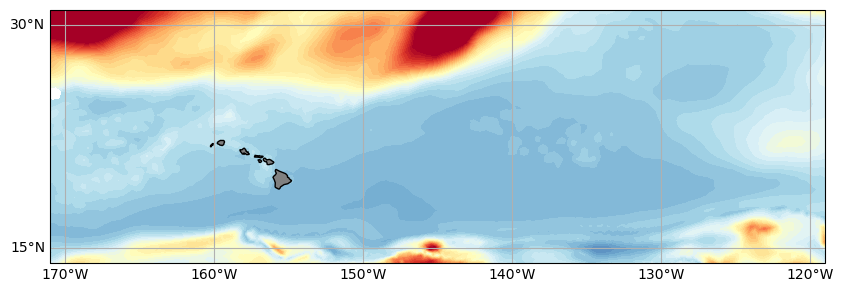

In [16]:
#---
# 1st depth level, 10 days later
#---
save_plots = True
width,height = 10,5 # 15,6; 18,7

res = 0.05
levels = np.arange(0, 2+res, res)

data_plot = np.copy(data1b)
data_plot[data_plot==0]        = -999
data_plot[np.isnan(data_plot)] = -999
mpasomap_run1 = MPASOMap(data = data_plot, name = 'Phytoplankton carbon biomass at '+\
                         str(int(zlevs[dd_list[0]]))+'m',\
                         units = 'mmol m-3', mesh = mpasmesh)
plt.figure(figsize=(width,height))
m = mpasomap_run1.plot(region = 'north_pacific', levels = levels, cmap = cmap1, ptype = 'contourf',colorbar=False) # pcolor, contourf
#plt.gca().colorbar.remove()
if save_plots:
    filename = 'Phyto_C_at_'+\
                         str(int(zlevs[dd_list[0]]))+'m_2014_March_15.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    del filename
    
    
#plt.figure(figsize=(width,height))
#m = mpasomap_run1.plot(region = 'north_pacific', levels = levels, cmap = cmap1, ptype = 'contourf') 
#plt.gca().set_visible(False)
#if save_plots:
#    filename = 'Phyto_C_at_'+\
#                         str(int(zlevs[dd_list[0]]))+'m_2014_March_15_COLORBAR.png'
#    print(savepath+filename)
#    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
#    filename = 'Phyto_C_at_'+\
#                         str(int(zlevs[dd_list[0]]))+'m_2014_March_15_COLORBAR.eps'
#    print(savepath+filename)
#    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
#    del filename
    
    

axis not defined
Plotting 'Phytoplankton carbon biomass at 60m (mmol m-3)' map in the 'north_pacific' (93442 data points)...
[0.3939697  0.42493036 0.6093601  ... 0.2530978  0.48093677 0.6193687 ]
-2.9999999e+34 2.9423537
/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/phyto_dynamics_subsampling/6year_run_v2/Phyto_C_at_60m_2014_March_15.png


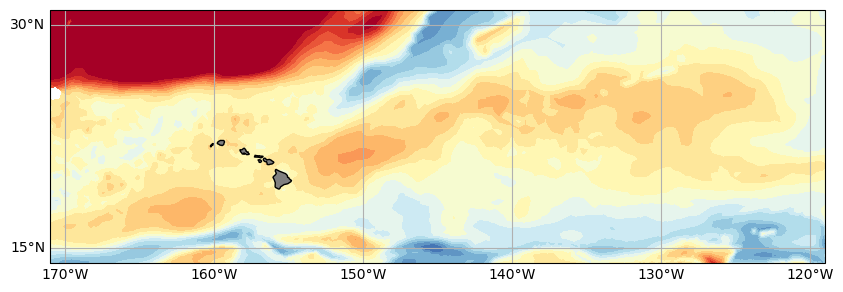

In [17]:
#---
# 2nd depth level, 10 days later
#---
#levels1 = levels/2
res = 0.05
levels = np.arange(0, 1.0+res, res)

data_plot = np.copy(data2b)
data_plot[data_plot==0]        = -999
data_plot[np.isnan(data_plot)] = -999
mpasomap_run1 = MPASOMap(data = data_plot, name = 'Phytoplankton carbon biomass at '+\
                         str(int(zlevs[dd_list[1]]))+'m',\
                         units = 'mmol m-3', mesh = mpasmesh)
plt.figure(figsize=(width,height))
m = mpasomap_run1.plot(region = 'north_pacific', levels = levels, cmap = cmap1, ptype = 'contourf',colorbar=False) # pcolor, contourf
if save_plots:
    filename = 'Phyto_C_at_'+\
                         str(int(zlevs[dd_list[1]]))+'m_2014_March_15.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    del filename

#plt.figure(figsize=(width,height))
#m = mpasomap_run1.plot(region = 'north_pacific', levels = levels, cmap = cmap1, ptype = 'contourf') 
#plt.gca().set_visible(False)
#if save_plots:
#    filename = 'Phyto_C_at_'+\
#                         str(int(zlevs[dd_list[1]]))+'m_2014_March_15_COLORBAR.png'
#    print(savepath+filename)
#    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
#    filename = 'Phyto_C_at_'+\
#                         str(int(zlevs[dd_list[1]]))+'m_2014_March_15_COLORBAR.eps'
#    print(savepath+filename)
#    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
#    del filename
    

In [ ]:
# make the time series plot nice (mark bloom peak each year for each depth level)
# make maps of a specific day and plot carbon at 40m, 80m, 120m near the focus region
# do subsampling exercise:
#    mismatch in magnitude vs. float density
#    mismatch in timing vs. float density


In [18]:
#----
# load daily float output
#----

path = '/global/cfs/cdirs/m4003/maltrud/6year/floats/'
year_list = ['0055','0056','0057','0058','0059','0060']

for yy in tqdm(range(0,len(year_list))):
    print('Load year '+year_list[yy])
    file1 = 'floats.year'+year_list[yy]+'.nc'   
    data = xr. open_dataset(path+file1)

    lon_1   = data['particleColumnLon'] #.values*rad_to_deg 
    lat_1   = data['particleColumnLat'] #.values*rad_to_deg 
    phy_1  = data['particleColumnTotalPhytoC'] #.values 
    
  #  # set missing values to NaN (deep ocean layers) 
  #  lat_1[temp_1==-1]=np.nan
  #  lon_1[temp_1==-1]=np.nan
  #  temp_1[temp_1==-1]=np.nan
  #  salt_1[salt_1==-1]=np.nan
    
    if yy==0: # first time
        lat_all = lat_1[:,0,:].values*rad_to_deg 
        lon_all = lon_1[:,0,:].values*rad_to_deg 
        phy_all1 = phy_1[:,dd_list[0],:].values
        phy_all2 = phy_1[:,dd_list[1],:].values
    else:
        lat_all = np.concatenate((lat_all,lat_1[:,0,:].values*rad_to_deg))
        lon_all = np.concatenate((lon_all,lon_1[:,0,:].values*rad_to_deg))
        phy_all1 = np.concatenate((phy_all1,phy_1[:,dd_list[0],:].values))
        phy_all2 = np.concatenate((phy_all2,phy_1[:,dd_list[1],:].values))
        
    del lon_1,lat_1,phy_1
    
# set missing values to NaN (deep ocean layers) 
phy_all1[phy_all1==-1]=np.nan # use salt here just in case temp accidentally is exactly -1 somewhere
phy_all2[phy_all2==-1]=np.nan

# the part below is just to make sure there is no random zeros in the fields...
phy_all1[phy_all1==0]=np.nan 
phy_all2[phy_all2==0]=np.nan 

print ('done')


  0%|          | 0/6 [00:00<?, ?it/s]

Load year 0055


 17%|█▋        | 1/6 [00:43<03:37, 43.49s/it]

Load year 0056


 33%|███▎      | 2/6 [01:29<03:00, 45.25s/it]

Load year 0057


 50%|█████     | 3/6 [02:08<02:06, 42.10s/it]

Load year 0058


 67%|██████▋   | 4/6 [02:46<01:21, 40.52s/it]

Load year 0059


 83%|████████▎ | 5/6 [03:24<00:39, 39.79s/it]

Load year 0060


100%|██████████| 6/6 [04:03<00:00, 40.55s/it]

done


In [31]:
#---
# test: don't sample all floats on day 1, 11, 21 etc (instead, sample some at day 5, 15, 25 etc)
#---

# get 10560 random numbers between 0-9
ind_start = np.random.choice(np.arange(0,10), size=phy_all1.shape[1], replace=True)
#print(ind_start.shape)
#print(ind_start)

phy_all1_10 = np.nan*np.ones([int(np.ceil(phy_all1.shape[0]/10)),phy_all1.shape[1]]) # 219 x 10560
phy_all2_10 = np.nan*np.ones([int(np.ceil(phy_all1.shape[0]/10)),phy_all1.shape[1]])
for ii in range(0,len(ind_start)):
    try:
        phy_all1_10[:,ii] = phy_all1[ind_start[ii]::10,ii]
    except:
        phy_all1_10[1:,ii] = phy_all1[ind_start[ii]::10,ii]
    try:
        phy_all2_10[:,ii] = phy_all2[ind_start[ii]::10,ii]
    except:
        phy_all2_10[1:,ii] = phy_all2[ind_start[ii]::10,ii]
        
#a1 = phy_all1[::10,:]
#a2 = phy_all2[::10,:]


In [32]:
#---
# 10-daily floats only
# IMPORTANT: don't sample all floats on day 1, 11, 21 etc (instead, sample some at day 5, 15, 25 etc)
#---

print(phy_all1.shape)

# get 10560 random numbers between 0-9 - assume that not all floats are thrown in on day 1
ind_start = np.random.choice(np.arange(0,10), size=phy_all1.shape[1], replace=True)

phy_all1_10 = np.nan*np.ones([int(np.ceil(phy_all1.shape[0]/10)),phy_all1.shape[1]]) # 219 x 10560
phy_all2_10 = np.nan*np.ones([int(np.ceil(phy_all1.shape[0]/10)),phy_all1.shape[1]])
lon_all_10 = np.nan*np.ones([int(np.ceil(phy_all1.shape[0]/10)),phy_all1.shape[1]])
lat_all_10 = np.nan*np.ones([int(np.ceil(phy_all1.shape[0]/10)),phy_all1.shape[1]])
for ii in range(0,len(ind_start)):
    try:
        phy_all1_10[:,ii] = phy_all1[ind_start[ii]::10,ii]
    except:
        phy_all1_10[1:,ii] = phy_all1[ind_start[ii]::10,ii]
    try:
        phy_all2_10[:,ii] = phy_all2[ind_start[ii]::10,ii]
    except:
        phy_all2_10[1:,ii] = phy_all2[ind_start[ii]::10,ii]
    try:
        lon_all_10[:,ii] = lon_all[ind_start[ii]::10,ii]
    except:
        lon_all_10[1:,ii] = lon_all[ind_start[ii]::10,ii]
    try:
        lat_all_10[:,ii] = lat_all[ind_start[ii]::10,ii]
    except:
        lat_all_10[1:,ii] = lat_all[ind_start[ii]::10,ii]
        

print(phy_all1_10.shape,lon_all_10.shape)

#---
# set data outside of region of interest to NaN
#---

print(np.nanmin(lon_all_10),np.nanmax(lon_all_10))

# loop over time and set everything to NaN outside of area of interest
for tt in range(0,lon_all_10.shape[0]):
    #ind = np.where((lat_all_10[tt,:]>15.0) & (lat_all_10[tt,:]<=30.0) &\
    #                   (lon_all_10[tt,:]>190.0) & (lon_all_10[tt,:]<=240.0))[0]
    ind_outside1 = np.where((lat_all_10[tt,:]<=15.0) | (lat_all_10[tt,:]>30.0))[0]
    ind_outside2 = np.where((lon_all_10[tt,:]<=190.0) | (lon_all_10[tt,:]>240.0))[0]
    
    lat_all_10[tt,ind_outside1] = np.nan
    lat_all_10[tt,ind_outside2] = np.nan
    lon_all_10[tt,ind_outside1] = np.nan
    lon_all_10[tt,ind_outside2] = np.nan
    phy_all1_10[tt,ind_outside1] = np.nan
    phy_all1_10[tt,ind_outside2] = np.nan
    phy_all2_10[tt,ind_outside1] = np.nan
    phy_all2_10[tt,ind_outside2] = np.nan
    
    del ind_outside1,ind_outside2

print(np.nanmin(lon_all_10),np.nanmax(lon_all_10))


(2183, 10560)
(219, 10560) (219, 10560)
0.0 359.9997368103459
190.00012595390703 239.99997935785177


In [ ]:

# do subsampling exercise:
#    mismatch in magnitude vs. float density
#    mismatch in timing vs. float density



In [33]:
ind_reg = np.where((lat>15.0) & (lat<=30.0) & (lon>190.0) & (lon<=240.0))[0]
print(ind_reg.shape)

(4614,)


In [34]:
#---
# get avg phyto biomass for all floats in focus region
#---

print(phy_all2_10.shape)

# get average for each day over all floats
phyC_1_mean = np.zeros(phy_all2_10.shape[0]) # first depth level
phyC_2_mean = np.zeros(phy_all1_10.shape[0]) # second depth level
num_floats_per_tt = np.zeros(phy_all1_10.shape[0])
for tt in range(0,phy_all1_10.shape[0]):
    ind = np.where(~np.isnan(phy_all1_10[tt,:]))[0]
    num_floats_per_tt[tt] = ind.shape[0]
    # NOTE: I need nanmean here as not all grid cells might be available (depending on depth level)
    phyC_1_mean[tt] = np.nanmean(phy_all1_10[tt,:]) 
    phyC_2_mean[tt] = np.nanmean(phy_all2_10[tt,:])
    del ind
        
bloom_peak_float_all1,bloom_time_float_all1 = get_all_6_bloom_peaks(phyC_1_mean)
bloom_peak_float_all2,bloom_time_float_all2 = get_all_6_bloom_peaks(phyC_2_mean)


(219, 10560)


In [35]:
#----
# SUBSAMPLE FLOATS
#----

# step1: create a list of float IDs that are in the region at least half of the time
min_time = 110 # 219 time steps in total (for 10-daily)
float_IDs_in_region = np.array([0])
for ff in range(0,phy_all1_10.shape[1]):
    ind = np.where(~np.isnan(phy_all1_10[:,ff]))[0]
    if ind.shape[0]>min_time:
        #print('append',ff)
        float_IDs_in_region = np.vstack((float_IDs_in_region,ff))

float_IDs_in_region = float_IDs_in_region[1:].transpose()
print(float_IDs_in_region.shape)
print(float_IDs_in_region) 



(1, 198)
[[  222   301   302   325   373   390   391   392   393   394   419   577
    585   601   703   728   757   758   921  1114  1189  1200  1245  1264
   1303  1366  1415  1433  1465  1483  1489  1504  1603  1637  1854  1864
   1877  1913  1947  1948  1951  2068  2101  2143  2235  2236  2259  2319
   2348  2434  2487  2517  2524  2545  2573  2719  2727  2728  2744  2876
   2894  3097  3260  3276  3394  3493  3559  3563  3571  3594  3675  3731
   3748  3818  3980  4035  4046  4294  4300  4500  4509  4550  4716  4778
   4804  4813  4848  4862  4914  4966  4991  5036  5063  5191  5404  5406
   5465  5527  5568  5614  5637  5668  5673  5729  5734  5795  5818  5865
   5997  6047  6205  6244  6254  6274  6332  6362  6376  6383  6417  6422
   6450  6465  6548  6596  6607  6640  6643  6665  6720  6782  6815  6828
   6927  7000  7006  7051  7090  7126  7179  7210  7256  7277  7279  7358
   7397  7434  7480  7515  7530  7534  7586  7596  7597  7619  7637  7729
   7860  7878  7962  7992  80

In [36]:
#---
# step 2: get number of floats according to target density of floats, choose subset of floats at random
#---

# for "area": indices of native mesh in focus region
ind_reg = np.where((lat>15.0) & (lat<=30.0) & (lon>190.0) & (lon<=240.0))[0]
    
# use unique float IDs to determine which floats to keep/kick out
num_floats_all = np.unique(float_IDs_in_region).shape[0]

# assess effect of subsampling for different target densities (global float number which is then scaled down)
#target_list = [1200,1100,1000,900,800,700,600,500,400,300,200,100]
target_list = [1200,800,400,200,100]

# repeat subsampling a number of times:
num_it = 5000

# for each iteration, determine characteristics of 6 blooms
bloom_peak_float_sub1 = np.zeros([6,len(target_list),num_it])  
bloom_time_float_sub1 = np.zeros([6,len(target_list),num_it]) 
bloom_peak_float_sub2 = np.zeros([6,len(target_list),num_it]) 
bloom_time_float_sub2 = np.zeros([6,len(target_list),num_it]) 
for mm in range(0,len(target_list)):
    # global target float density for 1000 bgc floats (in Mio km2 per float)
    global_target = np.sum(area)/1e12/target_list[mm]
    print('target density:',target_list[mm])

    num_floats_reduced = int(np.round(np.sum(area[ind_reg])/1e12/global_target)) 
    if num_floats_reduced>num_floats_all:
        print('Float density for all floats is lower than target float density! ')
    print('# of floats all vs. reduced:',num_floats_all,num_floats_reduced)

    for ii in tqdm(range(0,num_it)):
        ind_random = np.random.choice(np.unique(float_IDs_in_region), size=num_floats_reduced, replace=False)
        ind_random = np.sort(ind_random)
        #print(ind_random.shape,ind_random)

        aux1 = phy_all1_10[:,ind_random]
        aux2 = phy_all2_10[:,ind_random]
        #print(aux1.shape,aux2.shape)

        # get average for each day over all floats
        phyC_1_mean_sub = np.zeros(phy_all2_10.shape[0]) # first depth level
        phyC_2_mean_sub = np.zeros(phy_all1_10.shape[0]) # second depth level
        #num_floats_per_tt = np.zeros(phy_all1_10.shape[0])
        for tt in range(0,aux1.shape[0]):
            #ind = np.where(~np.isnan(phy_all1_10[tt,:]))[0]
            #num_floats_per_tt[tt] = ind.shape[0]
            # NOTE: I need nanmean here as not all grid cells might be available (depending on depth level)
            phyC_1_mean_sub[tt] = np.nanmean(aux1[tt,:]) 
            phyC_2_mean_sub[tt] = np.nanmean(aux2[tt,:])

        bloom_peak_float_sub1[:,mm,ii],bloom_time_float_sub1[:,mm,ii] = get_all_6_bloom_peaks(phyC_1_mean_sub)
        bloom_peak_float_sub2[:,mm,ii],bloom_time_float_sub2[:,mm,ii] = get_all_6_bloom_peaks(phyC_2_mean_sub)

        del phyC_1_mean_sub,phyC_2_mean_sub,aux1,aux2,ind_random
    
print('done')


target density: 1200
# of floats all vs. reduced: 198 28


100%|██████████| 5000/5000 [00:48<00:00, 103.44it/s]


target density: 800
# of floats all vs. reduced: 198 19


 18%|█▊        | 899/5000 [00:08<00:39, 103.98it/s]/tmp/ipykernel_1926658/1176130041.py:50: RuntimeWarning: Mean of empty slice
/tmp/ipykernel_1926658/1176130041.py:51: RuntimeWarning: Mean of empty slice
100%|██████████| 5000/5000 [00:48<00:00, 104.12it/s]


target density: 400
# of floats all vs. reduced: 198 9


100%|██████████| 5000/5000 [00:46<00:00, 107.98it/s]


target density: 200
# of floats all vs. reduced: 198 5


100%|██████████| 5000/5000 [00:45<00:00, 109.10it/s]


target density: 100
# of floats all vs. reduced: 198 2


100%|██████████| 5000/5000 [00:45<00:00, 108.76it/s]

done


Mean diff: 0.09116173107753768


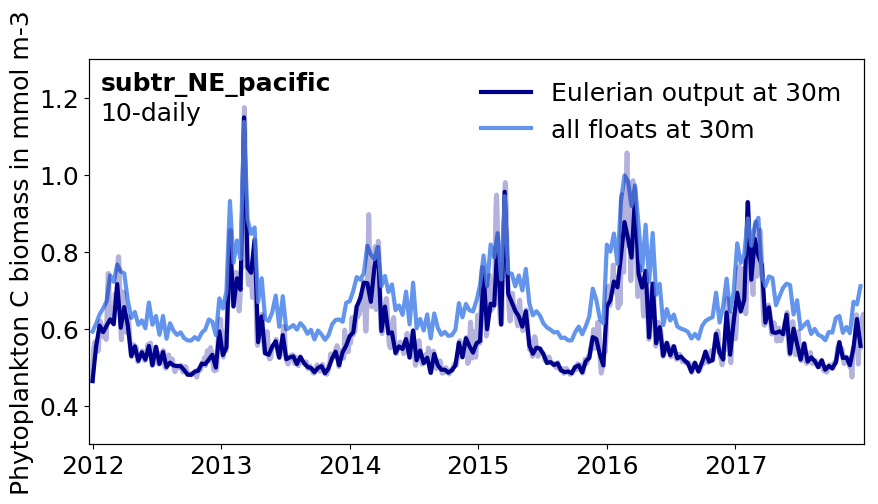

Mean diff: 0.03686215066251527


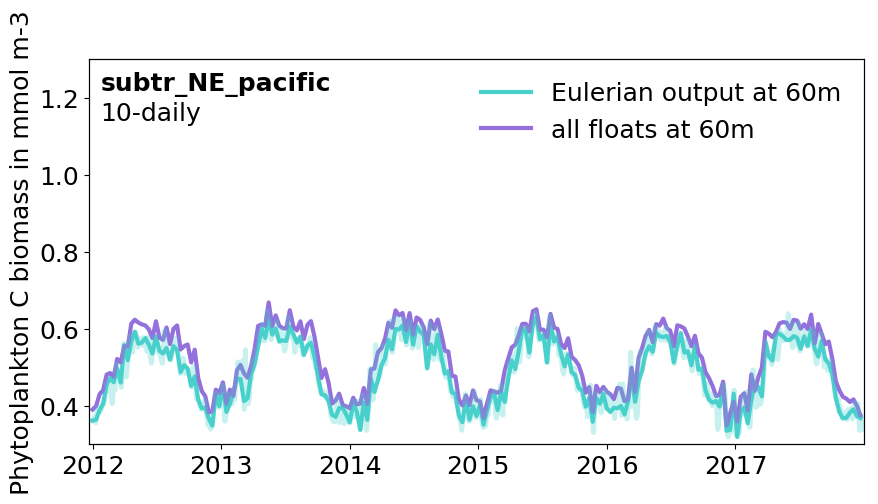

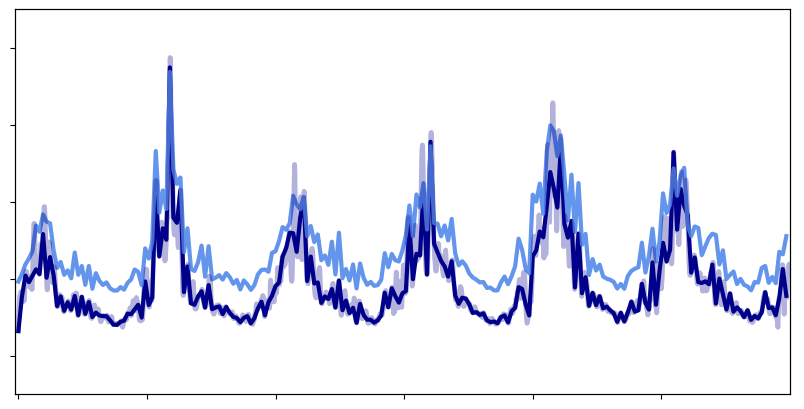

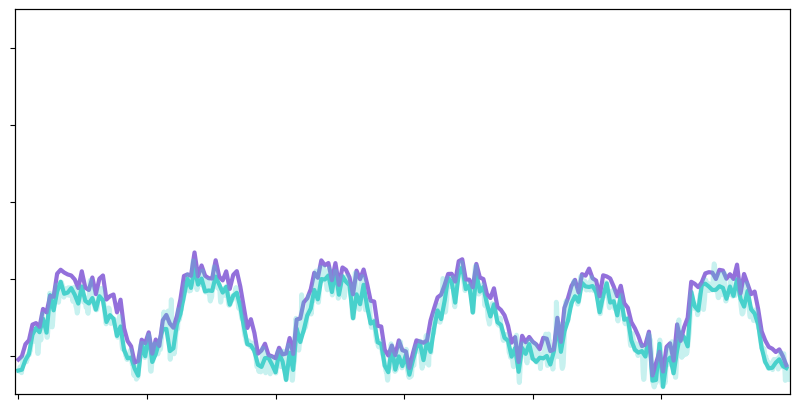

In [37]:
#---
# plot time series
#---
# Eulerian at depth 1
# Eulerian at depth 2
# all floats at depth 1
# all floats at depth 2

color1 = 'darkblue'
color2 = 'mediumturquoise'
color3 = 'cornflowerblue'
color4 = 'mediumpurple'
lw = 3
fs = 18
alpha1=0.3
ylim1,ylim2 = 0.3,1.3

save_plots = False

#---
# DEPTH 1
#---

fig, ax1 = plt.subplots(figsize=(width,height))
ax2 = ax1.twinx()
print('Mean diff:',np.mean(phyC_1_mean-data_all10[:,dd_list[0]]))

ax1.plot(range(0,len(data_all10[:,dd_list[0]])),data_all10[:,dd_list[0]],\
         color=color1,linewidth=lw,label='Eulerian output at '+str(int(zlevs[dd_list[0]]))+'m')
ax1.plot(range(0,len(data_all10[:,dd_list[0]])),phyC_1_mean,\
         color=color3,linewidth=lw,label='all floats at '+str(int(zlevs[dd_list[0]]))+'m')
ax1.set_xticks(np.arange(0,219,36.5))
ax1.set_xticklabels([])
ax1.set_yticks([0.2,0.4,0.6,0.8,1.0,1.2])
ax1.set_yticklabels([0.2,0.4,0.6,0.8,1.0,1.2])
ax1.set_ylabel('Phytoplankton C biomass in mmol m-3',fontsize=fs)
ax1.set_xlim((-1,219))
ax1.set_ylim((ylim1,ylim2))
ax1.annotate('10-daily',xy=(0.015,0.84),\
                xycoords='axes fraction',fontsize=fs,ha='left',color='k')

ax1.annotate(subregions[0],xy=(0.015,0.92),\
                xycoords='axes fraction',fontsize=fs,ha='left',color='k',fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=fs)
ax1.legend(frameon=False,prop={'size': 18})

ax2.plot(np.arange(0,len(data_all10[:,dd_list[0]]),0.1),data_all[:,dd_list[0]],\
         color=color1,linewidth=lw+0.5,alpha=alpha1,zorder=0)
ax2.set_xlim((-1,219))
ax2.set_ylim((ylim1,ylim2))
ax2.tick_params(axis='both', which='major', labelsize=fs)
ax2.set_xticks(np.arange(0,219,36.5))
ax2.set_xticklabels([2012,2013,2014,2015,2016,2017])
ax2.set_yticks([])
ax2.set_yticklabels([])

if save_plots:
    filename = 'TimeSeries_Phyto_C_at_'+\
                         str(int(zlevs[dd_list[0]]))+'m_2012_2017_with_all_floats.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    del filename
    
plt.show()

#---
# DEPTH 2
#---

fig, ax1 = plt.subplots(figsize=(width,height))
ax2 = ax1.twinx()

print('Mean diff:',np.mean(phyC_2_mean-data_all10[:,dd_list[1]]))
ax1.plot(range(0,len(data_all10[:,dd_list[1]])),data_all10[:,dd_list[1]],\
         color=color2,linewidth=lw,label='Eulerian output at '+str(int(zlevs[dd_list[1]]))+'m')
ax1.plot(range(0,len(data_all10[:,dd_list[1]])),phyC_2_mean,\
         color=color4,linewidth=lw,label='all floats at '+str(int(zlevs[dd_list[1]]))+'m')
ax1.set_xticks(np.arange(0,219,36.5))
ax1.set_xticklabels([])
ax1.set_yticks([0.2,0.4,0.6,0.8,1.0,1.2])
ax1.set_yticklabels([0.2,0.4,0.6,0.8,1.0,1.2])
ax1.set_ylabel('Phytoplankton C biomass in mmol m-3',fontsize=fs)
ax1.set_xlim((-1,219))
ax1.set_ylim((ylim1,ylim2))
ax1.annotate('10-daily',xy=(0.015,0.84),\
                xycoords='axes fraction',fontsize=fs,ha='left',color='k')

ax1.annotate(subregions[0],xy=(0.015,0.92),\
                xycoords='axes fraction',fontsize=fs,ha='left',color='k',fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=fs)
ax1.legend(frameon=False,prop={'size': 18})

ax2.plot(np.arange(0,len(data_all10[:,dd_list[1]]),0.1),data_all[:,dd_list[1]],\
         color=color2,linewidth=lw+0.5,alpha=alpha1,zorder=0)
ax2.set_xlim((-1,219))
ax2.set_ylim((ylim1,ylim2))
ax2.tick_params(axis='both', which='major', labelsize=fs)
ax2.set_xticks(np.arange(0,219,36.5))
ax2.set_xticklabels([2012,2013,2014,2015,2016,2017])
ax2.set_yticks([])
ax2.set_yticklabels([])

if save_plots:
    filename = 'TimeSeries_Phyto_C_at_'+\
                         str(int(zlevs[dd_list[1]]))+'m_2012_2017_with_all_floats.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    del filename
    
plt.show()

plot_eps = True
if plot_eps:

    #---
    # DEPTH 1
    #---

    fig, ax1 = plt.subplots(figsize=(width,height))
    ax2 = ax1.twinx()
    ax1.plot(range(0,len(data_all10[:,dd_list[0]])),data_all10[:,dd_list[0]],\
             color=color1,linewidth=lw,label='Eulerian output at '+str(int(zlevs[dd_list[0]]))+'m')
    ax1.plot(range(0,len(data_all10[:,dd_list[0]])),phyC_1_mean,\
             color=color3,linewidth=lw,label='all floats at '+str(int(zlevs[dd_list[0]]))+'m')
    ax1.set_xticks(np.arange(0,219,36.5))
    ax1.set_xticklabels([])
    ax1.set_yticks([0.2,0.4,0.6,0.8,1.0,1.2])
    ax1.set_yticklabels([])
    ax1.set_xlim((-1,219))
    ax1.set_ylim((ylim1,ylim2))
    ax1.tick_params(axis='both', which='major', labelsize=fs)
    
    ax2.plot(np.arange(0,len(data_all10[:,dd_list[0]]),0.1),data_all[:,dd_list[0]],\
             color=color1,linewidth=lw+0.5,alpha=alpha1,zorder=0)
    ax2.set_xlim((-1,219))
    ax2.set_ylim((ylim1,ylim2))
    ax2.tick_params(axis='both', which='major', labelsize=fs)
    ax2.set_xticks(np.arange(0,219,36.5))
    ax2.set_xticklabels([])
    ax2.set_yticks([])
    ax2.set_yticklabels([])

    if save_plots:
        filename = 'TimeSeries_Phyto_C_at_'+\
                             str(int(zlevs[dd_list[0]]))+'m_2012_2017_with_all_floats.eps'
        print(savepath+filename)
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
        del filename

    plt.show()

    #---
    # DEPTH 2
    #---

    fig, ax1 = plt.subplots(figsize=(width,height))
    ax2 = ax1.twinx()

    ax1.plot(range(0,len(data_all10[:,dd_list[1]])),data_all10[:,dd_list[1]],\
             color=color2,linewidth=lw,label='Eulerian output at '+str(int(zlevs[dd_list[1]]))+'m')
    ax1.plot(range(0,len(data_all10[:,dd_list[1]])),phyC_2_mean,\
             color=color4,linewidth=lw,label='all floats at '+str(int(zlevs[dd_list[1]]))+'m')
    ax1.set_xticks(np.arange(0,219,36.5))
    ax1.set_xticklabels([])
    ax1.set_yticks([0.2,0.4,0.6,0.8,1.0,1.2])
    ax1.set_yticklabels([])
    ax1.set_xlim((-1,219))
    ax1.set_ylim((ylim1,ylim2))
    ax1.tick_params(axis='both', which='major', labelsize=fs)
    
    ax2.plot(np.arange(0,len(data_all10[:,dd_list[1]]),0.1),data_all[:,dd_list[1]],\
             color=color2,linewidth=lw+0.5,alpha=alpha1,zorder=0)
    ax2.set_xlim((-1,219))
    ax2.set_ylim((ylim1,ylim2))
    ax2.tick_params(axis='both', which='major', labelsize=fs)
    ax2.set_xticks(np.arange(0,219,36.5))
    ax2.set_xticklabels([])
    ax2.set_yticks([])
    ax2.set_yticklabels([])

    if save_plots:
        filename = 'TimeSeries_Phyto_C_at_'+\
                             str(int(zlevs[dd_list[1]]))+'m_2012_2017_with_all_floats.eps'
        print(savepath+filename)
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
        del filename

    plt.show()


Mean diff: 0.09116173107753768


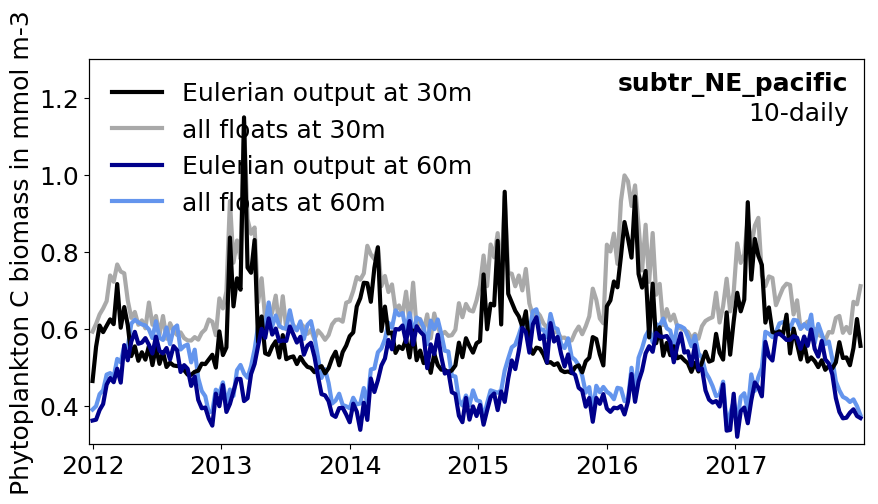

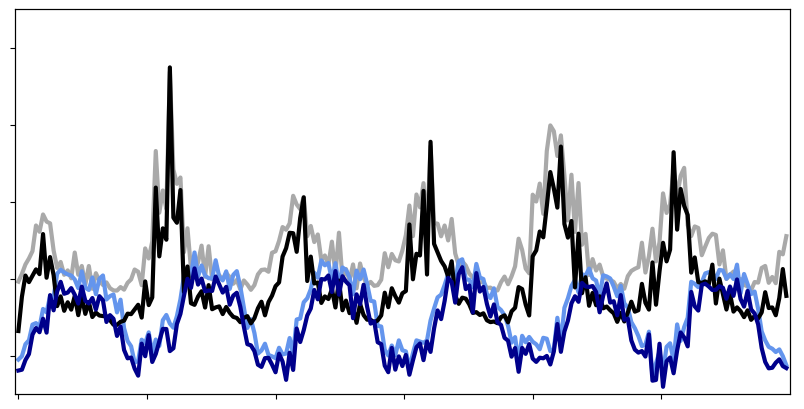

In [38]:
#---
# plot time series
#---
# Eulerian at depth 1
# Eulerian at depth 2
# all floats at depth 1
# all floats at depth 2

color1 = 'black'
color2 = 'darkblue' #'mediumturquoise'
color3 = 'darkgrey' #'cornflowerblue'
color4 = 'cornflowerblue' #'mediumpurple'
lw = 3
fs = 18
alpha1=0.3
ylim1,ylim2 = 0.3,1.3

save_plots = False

#---
# DEPTH 1
#---

fig, ax1 = plt.subplots(figsize=(width,height))
ax2 = ax1.twinx()
print('Mean diff:',np.mean(phyC_1_mean-data_all10[:,dd_list[0]]))

# depth 1
ax1.plot(range(0,len(data_all10[:,dd_list[0]])),data_all10[:,dd_list[0]],\
         color=color1,linewidth=lw,label='Eulerian output at '+str(int(zlevs[dd_list[0]]))+'m',zorder=3)
ax1.plot(range(0,len(data_all10[:,dd_list[0]])),phyC_1_mean,\
         color=color3,linewidth=lw,label='all floats at '+str(int(zlevs[dd_list[0]]))+'m',zorder=0)
# depth 2
ax1.plot(range(0,len(data_all10[:,dd_list[1]])),data_all10[:,dd_list[1]],\
         color=color2,linewidth=lw,label='Eulerian output at '+str(int(zlevs[dd_list[1]]))+'m',zorder=4)
ax1.plot(range(0,len(data_all10[:,dd_list[1]])),phyC_2_mean,\
         color=color4,linewidth=lw,label='all floats at '+str(int(zlevs[dd_list[1]]))+'m',zorder=1)

ax1.set_xticks(np.arange(0,219,36.5))
ax1.set_xticklabels([])
ax1.set_yticks([0.2,0.4,0.6,0.8,1.0,1.2])
ax1.set_yticklabels([0.2,0.4,0.6,0.8,1.0,1.2])
ax1.set_ylabel('Phytoplankton C biomass in mmol m-3',fontsize=fs)
ax1.set_xlim((-1,219))
ax1.set_ylim((ylim1,ylim2))
ax1.annotate('10-daily',xy=(0.98,0.84),\
                xycoords='axes fraction',fontsize=fs,ha='right',color='k')

ax1.annotate(subregions[0],xy=(0.98,0.92),\
                xycoords='axes fraction',fontsize=fs,ha='right',color='k',fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=fs)
ax1.legend(frameon=False,prop={'size': 18})

#ax2.plot(np.arange(0,len(data_all10[:,dd_list[0]]),0.1),data_all[:,dd_list[0]],\
#         color=color1,linewidth=lw+0.5,alpha=alpha1,zorder=0)
ax2.set_xlim((-1,219))
ax2.set_ylim((ylim1,ylim2))
ax2.tick_params(axis='both', which='major', labelsize=fs)
ax2.set_xticks(np.arange(0,219,36.5))
ax2.set_xticklabels([2012,2013,2014,2015,2016,2017])
ax2.set_yticks([])
ax2.set_yticklabels([])

if save_plots:
    filename = 'TimeSeries_combined_Phyto_C_at_'+\
                             str(int(zlevs[dd_list[0]]))+'m_'+\
                    str(int(zlevs[dd_list[1]]))+'m_2012_2017_with_all_floats.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    del filename
    
plt.show()

plot_eps = True
if plot_eps:

    #---
    # DEPTH 1
    #---

    fig, ax1 = plt.subplots(figsize=(width,height))
    ax2 = ax1.twinx()
    # depth 1
    ax1.plot(range(0,len(data_all10[:,dd_list[0]])),data_all10[:,dd_list[0]],\
             color=color1,linewidth=lw,label='Eulerian output at '+str(int(zlevs[dd_list[0]]))+'m',zorder=3)
    ax1.plot(range(0,len(data_all10[:,dd_list[0]])),phyC_1_mean,\
             color=color3,linewidth=lw,label='all floats at '+str(int(zlevs[dd_list[0]]))+'m',zorder=0)
    # depth 2
    ax1.plot(range(0,len(data_all10[:,dd_list[1]])),data_all10[:,dd_list[1]],\
             color=color2,linewidth=lw,label='Eulerian output at '+str(int(zlevs[dd_list[1]]))+'m',zorder=4)
    ax1.plot(range(0,len(data_all10[:,dd_list[1]])),phyC_2_mean,\
             color=color4,linewidth=lw,label='all floats at '+str(int(zlevs[dd_list[1]]))+'m',zorder=1)
    ax1.set_xticks(np.arange(0,219,36.5))
    ax1.set_xticklabels([])
    ax1.set_yticks([0.2,0.4,0.6,0.8,1.0,1.2])
    ax1.set_yticklabels([])
    ax1.set_xlim((-1,219))
    ax1.set_ylim((ylim1,ylim2))
    ax1.tick_params(axis='both', which='major', labelsize=fs)
    
    #ax2.plot(np.arange(0,len(data_all10[:,dd_list[0]]),0.1),data_all[:,dd_list[0]],\
    #         color=color1,linewidth=lw+0.5,alpha=alpha1,zorder=0)
    ax2.set_xlim((-1,219))
    ax2.set_ylim((ylim1,ylim2))
    ax2.tick_params(axis='both', which='major', labelsize=fs)
    ax2.set_xticks(np.arange(0,219,36.5))
    ax2.set_xticklabels([])
    ax2.set_yticks([])
    ax2.set_yticklabels([])

    if save_plots:
        filename = 'TimeSeries_combined_Phyto_C_at_'+\
                             str(int(zlevs[dd_list[0]]))+'m_'+\
                    str(int(zlevs[dd_list[1]]))+'m_2012_2017_with_all_floats.eps'
        print(savepath+filename)
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
        del filename

    plt.show()

    


In [39]:
# assess effect of subsampling for different target densities (global float number which is then scaled down)
#target_list = [1200,1100,1000,900,800,700,600,500,400,300,200,100]
target_list = [1200,800,400,200,100]

# repeat subsampling a number of times:
num_it = 5000

# for each iteration, determine characteristics of 6 blooms
num_floats_sub_list = np.zeros([len(target_list)])  
for mm in range(0,len(target_list)):
    global_target = np.sum(area)/1e12/target_list[mm]
    #print('target density:',target_list[mm])
    num_floats_sub_list[mm] = int(np.round(np.sum(area[ind_reg])/1e12/global_target)) 
    
print(num_floats_sub_list)


[28. 19.  9.  5.  2.]


1.011424320361641
[1.04124964 1.05602941 1.10112336 1.15987596 1.29190642]
/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/phyto_dynamics_subsampling/6year_run_v2/Subsampling_TimeSeries_combined_Phyto_C_bloom_magnitude_2012_2017_random_starts_ratio_floats_vs_Eulerian_30m.png


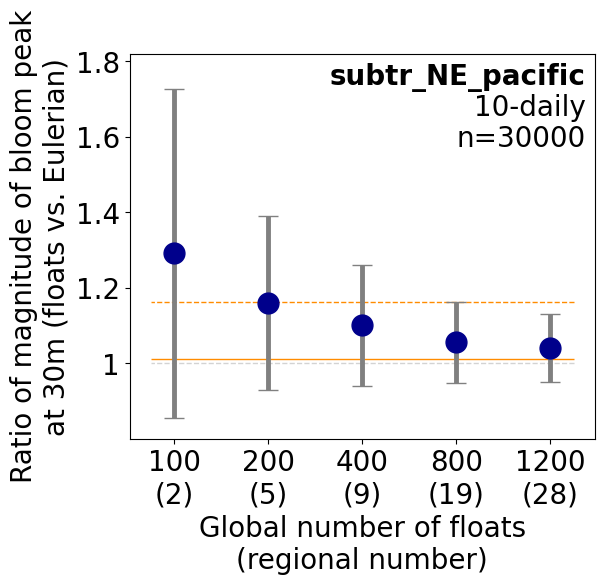

/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/phyto_dynamics_subsampling/6year_run_v2/Subsampling_TimeSeries_combined_Phyto_C_bloom_magnitude_2012_2017_random_starts_ratio_floats_vs_Eulerian_30m.eps


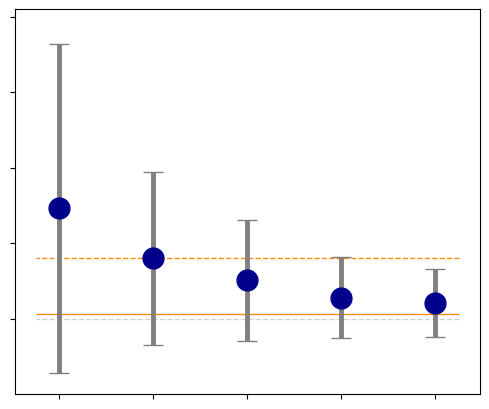

In [48]:
#----
# plot: bloom magnitude, depth 1
# 10-daily floats vs 10-daily Eulerian
#----
save_plots = True
plot_eps = True
width,height = 6,5 #10,5

aux1 = np.copy(bloom_peak_float_sub1)
aux1 = np.transpose(aux1,[1,0,2])
#aux1 = aux1.reshape(aux1.shape[0], -1)

aux2 = np.copy(bloom_peak_euler1)
aux2 = np.tile(aux2,[aux1.shape[0],aux1.shape[2],1])
aux2 = np.transpose(aux2,[0,2,1])

# compare "all floats" to Eulerian output
aux3 = np.nanmean(bloom_peak_float_all1 / bloom_peak_euler1) #np.nanmean(bloom_peak_float_all1 - bloom_peak_euler1)
print(aux3)

# compare bloom peak in subsampled float output to Eulerian bloom peaks
data_plot = aux1/aux2  #aux1 - aux2 # -> subtract bloom1, bloom2 etc 
#print(data_plot.shape)
data_plot_mean = np.nanmean(np.nanmean(data_plot,axis=2),axis=1) # avg over all blooms (i.e., 6 * num_it)
data_plot_std  = np.nanstd(data_plot.reshape(data_plot.shape[0], -1),axis=1) # get std over all blooms (i.e., 6 * num_it)
#print(data_plot_mean.shape)
#print(data_plot_std.shape)

print(data_plot_mean)

fs = 20

ms = 15
elw = 3.5
caps = 7

fig = plt.figure(figsize=(width,height))
plt.hlines(1,-0.25,len(target_list)-0.75,color='lightgrey',linewidth=1,linestyle='--')
plt.hlines(aux3,-0.25,len(target_list)-0.75,color='darkorange',linewidth=1)
# avg diff between "all floats" and Eulerian
# -> this is possibly because floats sample at 0 GMT, wihel the model is a full-day average!
a1 = np.mean(phyC_1_mean / data_all10[:,dd_list[0]])  #np.mean(phyC_1_mean-data_all10[:,dd_list[0]]) 
plt.hlines(a1,-0.25,len(target_list)-0.75,color='darkorange',linestyle='--',linewidth=1)
plt.errorbar(np.arange(0,len(target_list)),data_plot_mean,yerr=data_plot_std,\
                color='darkblue',linewidth=2.5,\
                    fmt='o',markersize=ms,capsize=caps,ecolor='gray',elinewidth=elw)
plt.ylabel('Ratio of magnitude of bloom peak\nat '+\
                         str(int(zlevs[dd_list[0]]))+'m (floats vs. Eulerian)',fontsize=fs)
plt.xlabel('Global number of floats\n(regional number)',fontsize=fs)
plt.xticks(np.arange(0,len(target_list)),[str(target_list[0])+'\n('+str(int(num_floats_sub_list[0]))+')',\
                       str(target_list[1])+'\n('+str(int(num_floats_sub_list[1]))+')',\
                       str(target_list[2])+'\n('+str(int(num_floats_sub_list[2]))+')',\
                       str(target_list[3])+'\n('+str(int(num_floats_sub_list[3]))+')',\
                       str(target_list[4])+'\n('+str(int(num_floats_sub_list[4]))+')'],fontsize=fs)
#plt.xticks(target_list,[str(target_list[0])+'\n('+str(int(num_floats_sub_list[0]))+')',\
#                       str(target_list[1])+'\n('+str(int(num_floats_sub_list[1]))+')',\
#                       str(target_list[2])+'\n('+str(int(num_floats_sub_list[2]))+')',\
#                       str(target_list[3])+'\n('+str(int(num_floats_sub_list[3]))+')',\
#                       str(target_list[4])+'\n('+str(int(num_floats_sub_list[4]))+')',\
#                       str(target_list[5])+'\n('+str(int(num_floats_sub_list[5]))+')',\
#                       str(target_list[6])+'\n('+str(int(num_floats_sub_list[6]))+')',\
#                       str(target_list[7])+'\n('+str(int(num_floats_sub_list[7]))+')',\
#                       str(target_list[8])+'\n('+str(int(num_floats_sub_list[8]))+')',\
#                       str(target_list[9])+'\n('+str(int(num_floats_sub_list[9]))+')',\
#                       str(target_list[10])+'\n('+str(int(num_floats_sub_list[10]))+')',\
#                       str(target_list[11])+'\n('+str(int(num_floats_sub_list[11]))+')'],fontsize=fs)
plt.yticks([1,1.2,1.4,1.6,1.8],[1,1.2,1.4,1.6,1.8],fontsize=fs)
plt.ylim((0.8,1.82))
plt.annotate('n='+str(6*num_it),xy=(0.98,0.76),\
                xycoords='axes fraction',fontsize=fs,ha='right',color='k')
plt.annotate('10-daily',xy=(0.98,0.84),\
                xycoords='axes fraction',fontsize=fs,ha='right',color='k')
plt.annotate(subregions[0],xy=(0.98,0.92),\
                xycoords='axes fraction',fontsize=fs,ha='right',color='k',fontweight='bold')
plt.gca().invert_xaxis()
if save_plots:
    filename = 'Subsampling_TimeSeries_combined_Phyto_C_bloom_magnitude_2012_2017_random_starts_ratio_floats_vs_Eulerian_'+\
                             str(int(zlevs[dd_list[0]]))+'m.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    del filename
    
plt.show()

if plot_eps:

    fig = plt.figure(figsize=(width,height))
    plt.hlines(1,-0.25,len(target_list)-0.75,color='lightgrey',linewidth=1,linestyle='--')
    plt.hlines(aux3,-0.25,len(target_list)-0.75,color='darkorange',linewidth=1)
    # avg diff between "all floats" and Eulerian
    # -> this is possibly because floats sample at 0 GMT, wihel the model is a full-day average!
    a1 = np.mean(phyC_1_mean/data_all10[:,dd_list[0]])  #np.mean(phyC_1_mean-data_all10[:,dd_list[0]]) 
    plt.hlines(a1,-0.25,len(target_list)-0.75,color='darkorange',linestyle='--',linewidth=1)
    plt.errorbar(np.arange(0,len(target_list)),data_plot_mean,yerr=data_plot_std,\
                    color='darkblue',linewidth=2.5,\
                        fmt='o',markersize=ms,capsize=caps,ecolor='gray',elinewidth=elw)
    plt.xticks(np.arange(0,len(target_list)),[],fontsize=fs)
    plt.yticks([1,1.2,1.4,1.6,1.8],[],fontsize=fs)
    plt.ylim((0.8,1.82))
    plt.gca().invert_xaxis()
    if save_plots:
        filename = 'Subsampling_TimeSeries_combined_Phyto_C_bloom_magnitude_2012_2017_random_starts_ratio_floats_vs_Eulerian_'+\
                             str(int(zlevs[dd_list[0]]))+'m.eps'
        print(savepath+filename)
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
        del filename

    plt.show()



1.0539918516110307
[1.07926119 1.08885997 1.11589651 1.1490238  1.22717074]
/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/phyto_dynamics_subsampling/6year_run_v2/Subsampling_TimeSeries_combined_Phyto_C_bloom_magnitude_2012_2017_random_starts_ratio_floats_vs_Eulerian_60m.png


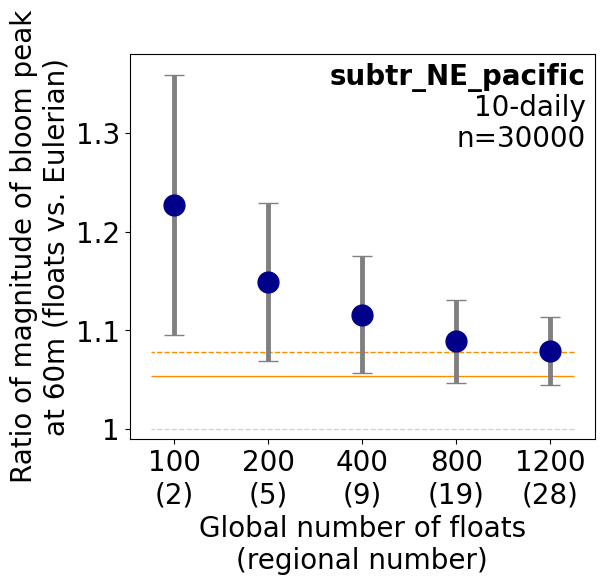

/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/phyto_dynamics_subsampling/6year_run_v2/Subsampling_TimeSeries_combined_Phyto_C_bloom_magnitude_2012_2017_random_starts_ratio_floats_vs_Eulerian_60m.eps


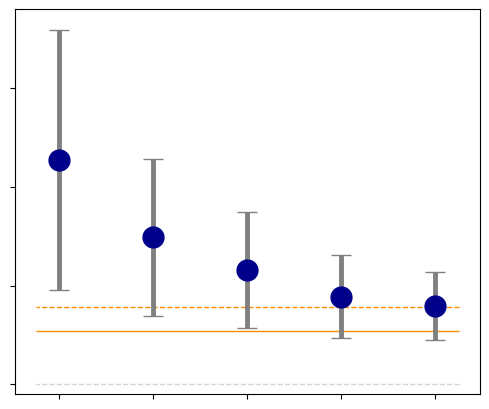

In [49]:
#----
# plot: bloom magnitude, depth 2
# 10-daily floats vs 10-daily Eulerian
#----

aux1 = np.copy(bloom_peak_float_sub2)
aux1 = np.transpose(aux1,[1,0,2])
#aux1 = aux1.reshape(aux1.shape[0], -1)

aux2 = np.copy(bloom_peak_euler2)
aux2 = np.tile(aux2,[aux1.shape[0],aux1.shape[2],1])
aux2 = np.transpose(aux2,[0,2,1])

# compare "all floats" to Eulerian output
aux3 = np.nanmean(bloom_peak_float_all2 / bloom_peak_euler2) #np.nanmean(bloom_peak_float_all2 - bloom_peak_euler2)
print(aux3)

# compare bloom peak in subsampled float output to Eulerian bloom peaks
data_plot = aux1 / aux2 # aux1 - aux2 # -> subtract bloom1, bloom2 etc 
#print(data_plot.shape)
data_plot_mean = np.nanmean(np.nanmean(data_plot,axis=2),axis=1) # avg over all blooms (i.e., 6 * num_it)
data_plot_std  = np.nanstd(data_plot.reshape(data_plot.shape[0], -1),axis=1) # get std over all blooms (i.e., 6 * num_it)
#print(data_plot_mean.shape)
#print(data_plot_std.shape)

print(data_plot_mean)


fig = plt.figure(figsize=(width,height))
plt.hlines(1,-0.25,len(target_list)-0.75,color='lightgrey',linewidth=1,linestyle='--')
plt.hlines(aux3,-0.25,len(target_list)-0.75,color='darkorange',linewidth=1)# avg diff between "all floats" and Eulerian
# -> this is possibly because floats sample at 0 GMT, wihel the model is a full-day average!
a1 = np.mean(phyC_2_mean/data_all10[:,dd_list[1]])  #np.mean(phyC_2_mean-data_all10[:,dd_list[1]]) 
plt.hlines(a1,-0.25,len(target_list)-0.75,color='darkorange',linestyle='--',linewidth=1)
plt.errorbar(np.arange(0,len(target_list)),data_plot_mean,yerr=data_plot_std,\
                color='darkblue',linewidth=2.5,\
                    fmt='o',markersize=ms,capsize=caps,ecolor='gray',elinewidth=elw)
plt.ylabel('Ratio of magnitude of bloom peak\nat '+\
                         str(int(zlevs[dd_list[1]]))+'m (floats vs. Eulerian)',fontsize=fs)
plt.xlabel('Global number of floats\n(regional number)',fontsize=fs)
plt.xticks(np.arange(0,len(target_list)),[str(target_list[0])+'\n('+str(int(num_floats_sub_list[0]))+')',\
                       str(target_list[1])+'\n('+str(int(num_floats_sub_list[1]))+')',\
                       str(target_list[2])+'\n('+str(int(num_floats_sub_list[2]))+')',\
                       str(target_list[3])+'\n('+str(int(num_floats_sub_list[3]))+')',\
                       str(target_list[4])+'\n('+str(int(num_floats_sub_list[4]))+')'],fontsize=fs)
plt.yticks([1,1.1,1.2,1.3],[1,1.1,1.2,1.3],fontsize=fs)
plt.ylim((0.99,1.38))
plt.gca().invert_xaxis()
plt.annotate('n='+str(6*num_it),xy=(0.98,0.76),\
                xycoords='axes fraction',fontsize=fs,ha='right',color='k')
plt.annotate('10-daily',xy=(0.98,0.84),\
                xycoords='axes fraction',fontsize=fs,ha='right',color='k')
plt.annotate(subregions[0],xy=(0.98,0.92),\
                xycoords='axes fraction',fontsize=fs,ha='right',color='k',fontweight='bold')
if save_plots:
    filename = 'Subsampling_TimeSeries_combined_Phyto_C_bloom_magnitude_2012_2017_random_starts_ratio_floats_vs_Eulerian_'+\
                             str(int(zlevs[dd_list[1]]))+'m.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    del filename
    
plt.show()

if plot_eps:
    fig = plt.figure(figsize=(width,height))
    plt.hlines(1,-0.25,len(target_list)-0.75,color='lightgrey',linewidth=1,linestyle='--')
    plt.hlines(aux3,-0.25,len(target_list)-0.75,color='darkorange',linewidth=1)# avg diff between "all floats" and Eulerian
    # -> this is possibly because floats sample at 0 GMT, wihel the model is a full-day average!
    a1 = np.mean(phyC_2_mean/data_all10[:,dd_list[1]])  #np.mean(phyC_2_mean-data_all10[:,dd_list[1]]) 
    plt.hlines(a1,-0.25,len(target_list)-0.75,color='darkorange',linestyle='--',linewidth=1)
    plt.errorbar(np.arange(0,len(target_list)),data_plot_mean,yerr=data_plot_std,\
                    color='darkblue',linewidth=2.5,\
                        fmt='o',markersize=ms,capsize=caps,ecolor='gray',elinewidth=elw)
    plt.xticks(np.arange(0,len(target_list)),[],fontsize=fs)
    plt.yticks([1,1.1,1.2,1.3],[],fontsize=fs)
    plt.ylim((0.99,1.38))
    plt.gca().invert_xaxis()
    if save_plots:
        filename = 'Subsampling_TimeSeries_combined_Phyto_C_bloom_magnitude_2012_2017_random_starts_ratio_floats_vs_Eulerian_'+\
                             str(int(zlevs[dd_list[1]]))+'m.eps'
        print(savepath+filename)
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
        del filename

    plt.show()



In [54]:
print(bloom_peak_euler1_daily)
print(bloom_peak_float_sub1.shape)

#---
# DEPTH1 
#---
aux1 = np.copy(bloom_peak_float_sub1)
aux1 = np.transpose(aux1,[1,0,2])

aux2 = np.copy(bloom_peak_euler1_daily)
aux2 = np.tile(aux2,[aux1.shape[0],aux1.shape[2],1])
aux2 = np.transpose(aux2,[0,2,1])

# compare "all floats" to Eulerian output
aux3 = np.nanmean(bloom_peak_float_all1 / bloom_peak_euler1) #np.nanmean(bloom_peak_float_all1 - bloom_peak_euler1)
print(aux3)

# compare bloom peak in subsampled float output to Eulerian bloom peaks
data_plot = aux1 / aux2 #aux1 - aux2 # -> subtract bloom1, bloom2 etc 
#print(data_plot.shape)
data_plot_mean = np.nanmean(np.nanmean(data_plot,axis=2),axis=1) # avg over all blooms (i.e., 6 * num_it)
data_plot_std  = np.nanstd(data_plot.reshape(data_plot.shape[0], -1),axis=1) # get std over all blooms (i.e., 6 * num_it)



[0.78709959 1.17428744 0.89656891 0.97976189 1.05670925 0.92840294]
(6, 5, 5000)
1.011424320361641


1.011424320361641
1.0539918516110307

at 30m (ratio 10-daily floats vs 10-daily Eulerian, ratio 10-daily floats vs daily Eulerian)
1200 1.0412496418819985 0.9801694202493151
800 1.0560294133512547 0.9939209801046994
400 1.1011233575627688 1.036042981349543
200 1.1598759611735707 1.0911856252177496
100 1.2919064241526332 1.2153617123178904

at 60m (ratio 10-daily floats vs 10-daily Eulerian, ratio 10-daily floats vs daily Eulerian)
1200 1.0792611910035355 1.0498465386927012
800 1.0888599699927604 1.059188151487778
400 1.1158965052223417 1.0854712383505138
200 1.1490238024657666 1.1176729821266298
100 1.2271707430973742 1.193651811142888



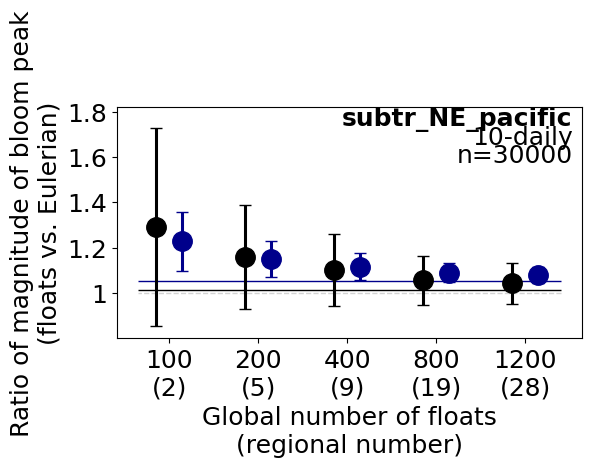


30m (target density / mean / std): 1200 1.0412496418819985 0.08956211810614241
30m (target density / mean / std): 800 1.0560294133512547 0.1078201003249153
30m (target density / mean / std): 400 1.1011233575627688 0.15999581652419254
30m (target density / mean / std): 200 1.1598759611735707 0.22981920058664781
30m (target density / mean / std): 100 1.2919064241526332 0.43642319441040606

60m (target density / mean / std): 1200 1.0792611910035355 0.03469572160553416
60m (target density / mean / std): 800 1.0888599699927604 0.042119992761690025
60m (target density / mean / std): 400 1.1158965052223417 0.05905245811493513
60m (target density / mean / std): 200 1.1490238024657666 0.07966512472087106
60m (target density / mean / std): 100 1.2271707430973742 0.13180365504573563


In [67]:

#----
# plot: bloom magnitude, COMBINE BOTH DEPTHS
# 10-daily floats vs 10-daily Eulerian
#----
save_plots = False
plot_eps = False

#---
# DEPTH1 
#---
aux1 = np.copy(bloom_peak_float_sub1)
aux1 = np.transpose(aux1,[1,0,2])

aux2 = np.copy(bloom_peak_euler1)
aux2 = np.tile(aux2,[aux1.shape[0],aux1.shape[2],1])
aux2 = np.transpose(aux2,[0,2,1])

# bloom magnitude based on daily Eulerian output
aux2b = np.copy(bloom_peak_euler1_daily)
aux2b = np.tile(aux2b,[aux1.shape[0],aux1.shape[2],1])
aux2b = np.transpose(aux2b,[0,2,1])

# compare "all floats" to Eulerian output
aux3 = np.nanmean(bloom_peak_float_all1 / bloom_peak_euler1) #np.nanmean(bloom_peak_float_all1 - bloom_peak_euler1)
print(aux3)

# compare bloom peak in subsampled float output to Eulerian bloom peaks
data_plot = aux1 / aux2          # get ratio: 10-daily floats vs 10-daily Eulerian
data_plot_daily = aux1 / aux2b   # get ratio: 10-daily floats vs daily Eulerian
#print(data_plot.shape)
data_plot_mean = np.nanmean(np.nanmean(data_plot,axis=2),axis=1) # avg over all blooms (i.e., 6 * num_it)
data_plot_std  = np.nanstd(data_plot.reshape(data_plot.shape[0], -1),axis=1) # get std over all blooms (i.e., 6 * num_it)
data_plot_mean_daily = np.nanmean(np.nanmean(data_plot_daily,axis=2),axis=1) # avg over all blooms (i.e., 6 * num_it)
data_plot_std_daily  = np.nanstd(data_plot_daily.reshape(data_plot_daily.shape[0], -1),axis=1) # get std over all blooms (i.e., 6 * num_it)

del aux1,aux2,aux2b

#---
# DEPTH2
#---
aux1b = np.copy(bloom_peak_float_sub2)
aux1b = np.transpose(aux1b,[1,0,2])

aux2b = np.copy(bloom_peak_euler2)
aux2b = np.tile(aux2b,[aux1b.shape[0],aux1b.shape[2],1])
aux2b = np.transpose(aux2b,[0,2,1])

# bloom magnitude based on daily Eulerian output
aux2c = np.copy(bloom_peak_euler2_daily)
aux2c = np.tile(aux2c,[aux1b.shape[0],aux1b.shape[2],1])
aux2c = np.transpose(aux2c,[0,2,1])

# compare "all floats" to Eulerian output
aux3b = np.nanmean(bloom_peak_float_all2 / bloom_peak_euler2) #np.nanmean(bloom_peak_float_all2 - bloom_peak_euler2)
print(aux3b)

# compare bloom peak in subsampled float output to Eulerian bloom peaks
data_plotb = aux1b / aux2b         # get ratio: 10-daily floats vs 10-daily Eulerian
data_plot_dailyb = aux1b / aux2c   # get ratio: 10-daily floats vs daily Eulerian
#print(data_plot.shape)
data_plot_meanb = np.nanmean(np.nanmean(data_plotb,axis=2),axis=1) # avg over all blooms (i.e., 6 * num_it)
data_plot_stdb  = np.nanstd(data_plotb.reshape(data_plotb.shape[0], -1),axis=1) # get std over all blooms (i.e., 6 * num_it)
data_plot_mean_dailyb = np.nanmean(np.nanmean(data_plot_dailyb,axis=2),axis=1) # avg over all blooms (i.e., 6 * num_it)
data_plot_std_dailyb  = np.nanstd(data_plot_dailyb.reshape(data_plot_dailyb.shape[0], -1),axis=1) # get std over all blooms (i.e., 6 * num_it)

del aux1b,aux2b,aux2c

print()
print('at 30m (ratio 10-daily floats vs 10-daily Eulerian, ratio 10-daily floats vs daily Eulerian)')
for tt in range(0,len(target_list)):
    print(target_list[tt],data_plot_mean[tt],data_plot_mean_daily[tt])
print()
print('at 60m (ratio 10-daily floats vs 10-daily Eulerian, ratio 10-daily floats vs daily Eulerian)')
for tt in range(0,len(target_list)):
    print(target_list[tt],data_plot_meanb[tt],data_plot_mean_dailyb[tt])
print()

fs = 18

ms = 14
elw = 2.2
caps = 4.5
color1 = 'k'
color2 = 'darkblue'

width,height = 6,3 #15,6; 10,5

fig = plt.figure(figsize=(width,height))
plt.hlines(1,-0.25,len(target_list)-0.5,color='lightgrey',linewidth=1,linestyle='--')
plt.hlines(aux3,-0.25,len(target_list)-0.5,color=color1,linewidth=1)
plt.hlines(aux3b,-0.25,len(target_list)-0.5,color=color2,linewidth=1)
# avg diff between "all floats" and Eulerian
# -> this is possibly because floats sample at 0 GMT, wihel the model is a full-day average!
#a1 = np.mean(phyC_1_mean-data_all10[:,dd_list[0]]) 
#plt.hlines(a1,target_list[0]+20,target_list[-1]-20,color='darkorange',linestyle='--',linewidth=1)
plt.errorbar(np.arange(0.3,len(target_list)),data_plot_mean,yerr=data_plot_std,\
                color=color1,linewidth=2.5,\
                    fmt='o',markersize=ms,capsize=caps,ecolor=color1,elinewidth=elw)
# PLOT ratio 10-daily floats vs daily Eulerian (for comparison)
#plt.plot(np.arange(0.3,len(target_list)),data_plot_mean_daily,'rx')
#plt.plot(np.arange(0.3,len(target_list)),data_plot_mean_daily+data_plot_std_daily,'ro')
#plt.plot(np.arange(0.3,len(target_list)),data_plot_mean_daily-data_plot_std_daily,'ro')

target_list2 = np.arange(0,len(target_list)) #[x+30 for x in target_list]
plt.errorbar(target_list2,data_plot_meanb,yerr=data_plot_stdb,\
                color=color2,linewidth=2.5,\
                    fmt='o',markersize=ms,capsize=caps,ecolor=color2,elinewidth=elw)
# PLOT ratio 10-daily floats vs daily Eulerian (for comparison)
#plt.plot(target_list2,data_plot_mean_dailyb,'rx')
#plt.plot(target_list2,data_plot_mean_dailyb+data_plot_std_dailyb,'ro')
#plt.plot(target_list2,data_plot_mean_dailyb-data_plot_std_dailyb,'ro')

plt.ylabel('Ratio of magnitude of bloom peak\n(floats vs. Eulerian)',fontsize=fs)
plt.xlabel('Global number of floats\n(regional number)',fontsize=fs)
target_list2 = np.arange(0.15,len(target_list)) #[x+15 for x in target_list]
plt.xticks(target_list2,[str(target_list[0])+'\n('+str(int(num_floats_sub_list[0]))+')',\
                       str(target_list[1])+'\n('+str(int(num_floats_sub_list[1]))+')',\
                       str(target_list[2])+'\n('+str(int(num_floats_sub_list[2]))+')',\
                       str(target_list[3])+'\n('+str(int(num_floats_sub_list[3]))+')',\
                       str(target_list[4])+'\n('+str(int(num_floats_sub_list[4]))+')'],fontsize=fs)
plt.yticks([1,1.2,1.4,1.6,1.8],[1,1.2,1.4,1.6,1.8],fontsize=fs)
plt.ylim((0.8,1.82))
plt.gca().invert_xaxis()
plt.annotate('n='+str(6*num_it),xy=(0.98,0.76),\
                xycoords='axes fraction',fontsize=fs,ha='right',color='k')
plt.annotate('10-daily',xy=(0.98,0.84),\
                xycoords='axes fraction',fontsize=fs,ha='right',color='k')
plt.annotate(subregions[0],xy=(0.98,0.92),\
                xycoords='axes fraction',fontsize=fs,ha='right',color='k',fontweight='bold')
if save_plots:
    filename = 'Subsampling_TimeSeries_combined_Phyto_C_bloom_magnitude_2012_2017_random_starts_ratio_floats_vs_Eulerian.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    del filename
    
plt.show()

if plot_eps:

    fig = plt.figure(figsize=(width,height))
    plt.hlines(0,-0.25,len(target_list)-0.5,color='lightgrey',linewidth=1,linestyle='--')
    plt.hlines(aux3,-0.25,len(target_list)-0.5,color=color1,linewidth=1)
    plt.hlines(aux3b,-0.25,len(target_list)-0.5,color=color2,linewidth=1)
    # avg diff between "all floats" and Eulerian
    # -> this is possibly because floats sample at 0 GMT, wihel the model is a full-day average!
    #a1 = np.mean(phyC_1_mean-data_all10[:,dd_list[0]]) 
    #plt.hlines(a1,target_list[0]+20,target_list[-1]-20,color='darkorange',linestyle='--',linewidth=1)
    plt.errorbar(np.arange(0.3,len(target_list)),data_plot_mean,yerr=data_plot_std,\
                    color=color1,linewidth=2.5,\
                        fmt='o',markersize=ms,capsize=caps,ecolor=color1,elinewidth=elw)

    target_list2 = np.arange(0,len(target_list)) #[x+30 for x in target_list]
    plt.errorbar(target_list2,data_plot_meanb,yerr=data_plot_stdb,\
                color=color2,linewidth=2.5,\
                    fmt='o',markersize=ms,capsize=caps,ecolor=color2,elinewidth=elw)
    target_list2 = np.arange(0.15,len(target_list)) #[x+15 for x in target_list]
    plt.xticks(target_list2,[],fontsize=fs)
    plt.yticks([1,1.2,1.4,1.6,1.8],[],fontsize=fs)
    plt.ylim((0.8,1.82))
    plt.gca().invert_xaxis()
    if save_plots:
        filename = 'Subsampling_TimeSeries_combined_Phyto_C_bloom_magnitude_2012_2017_random_starts_ratio_floats_vs_Eulerian.eps'
        print(savepath+filename)
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
        del filename

    plt.show()

print('')  
for tt in range(0,len(target_list)):
    print('30m (target density / mean / std):',target_list[tt],data_plot_mean[tt],data_plot_std[tt])
    
print('')
for tt in range(0,len(target_list)):
    print('60m (target density / mean / std):',target_list[tt],data_plot_meanb[tt],data_plot_stdb[tt])

    

-0.5
-0.3333333333333333

at 30m (difference 10-daily floats vs 10-daily Eulerian, ratio 10-daily floats vs daily Eulerian)
1200 -2.612 1.8880000000000001
800 -1.3700000000000003 3.1300000000000003
400 2.2293333333333334 6.729333333333333
200 5.703999999999999 10.203999999999999
100 9.338333333333333 13.838333333333333

at 60m (difference 10-daily floats vs 10-daily Eulerian, ratio 10-daily floats vs daily Eulerian)
1200 2.3296666666666668 5.163000000000001
800 3.172000000000001 6.005333333333334
400 3.9273333333333342 6.7606666666666655
200 -0.1826666666666658 2.650666666666668
100 -9.918 -7.084666666666666



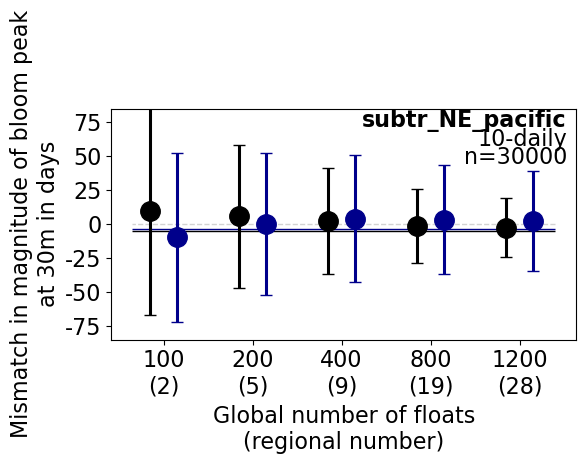


30m (target density / mean / std): 1200 -2.612 21.950796249794674
30m (target density / mean / std): 800 -1.3700000000000003 26.991784552588097
30m (target density / mean / std): 400 2.2293333333333334 39.271406980425624
30m (target density / mean / std): 200 5.703999999999999 52.77661461922948
30m (target density / mean / std): 100 9.338333333333333 75.95098549210684

60m (target density / mean / std): 1200 2.3296666666666668 36.97912906702314
60m (target density / mean / std): 800 3.172000000000001 40.10409475352859
60m (target density / mean / std): 400 3.9273333333333342 46.671147970549086
60m (target density / mean / std): 200 -0.1826666666666658 52.306149729793304
60m (target density / mean / std): 100 -9.918 61.96396756180158


In [72]:
#----
# plot: bloom timing, BOTH DEPTHS COMBINED
#----

save_plots = False
plot_eps   = False
width,height = 6,3

#---
# depth 1
#---
aux1 = np.copy(bloom_time_float_sub1)
aux1 = np.transpose(aux1,[1,0,2])
#aux1 = aux1.reshape(aux1.shape[0], -1)

aux2 = np.copy(bloom_time_euler1)
aux2 = np.tile(aux2,[aux1.shape[0],aux1.shape[2],1])
aux2 = np.transpose(aux2,[0,2,1])

# bloom magnitude based on daily Eulerian output
aux2b = np.copy(bloom_time_euler1_daily)
aux2b = np.tile(aux2b,[aux1.shape[0],aux1.shape[2],1])
aux2b = np.transpose(aux2b,[0,2,1])

# compare "all floats" to Eulerian output
aux3 = np.nanmean(bloom_time_float_all1 - bloom_time_euler1)
print(aux3)

# compare bloom peak in subsampled float output to Eulerian bloom peaks
data_plot = aux1 - aux2          # get ratio: 10-daily floats vs 10-daily Eulerian
data_plot_daily = 10*aux1 - aux2b   # get ratio: 10-daily floats vs daily Eulerian
data_plot_mean = np.nanmean(np.mean(data_plot,axis=2),axis=1) # avg over all blooms (i.e., 6 * num_it)
data_plot_std  = np.nanstd(data_plot.reshape(data_plot.shape[0], -1),axis=1) # get std over all blooms (i.e., 6 * num_it)
data_plot_mean_daily = np.nanmean(np.nanmean(data_plot_daily,axis=2),axis=1) # avg over all blooms (i.e., 6 * num_it)
data_plot_std_daily  = np.nanstd(data_plot_daily.reshape(data_plot_daily.shape[0], -1),axis=1) # get std over all blooms (i.e., 6 * num_it)

del aux1,aux2,aux2b

#---
# depth 2
#---
aux1b = np.copy(bloom_time_float_sub2)
aux1b = np.transpose(aux1b,[1,0,2])

aux2b = np.copy(bloom_time_euler2)
aux2b = np.tile(aux2b,[aux1b.shape[0],aux1b.shape[2],1])
aux2b = np.transpose(aux2b,[0,2,1])

# bloom magnitude based on daily Eulerian output
aux2c = np.copy(bloom_time_euler2_daily)
aux2c = np.tile(aux2c,[aux1b.shape[0],aux1b.shape[2],1])
aux2c = np.transpose(aux2c,[0,2,1])

# compare "all floats" to Eulerian output
aux3b = np.nanmean(bloom_time_float_all2 - bloom_time_euler2)
print(aux3b)

# compare bloom peak in subsampled float output to Eulerian bloom peaks
data_plotb = aux1b - aux2b         # get ratio: 10-daily floats vs 10-daily Eulerian
data_plot_dailyb = 10*aux1b - aux2c   # get ratio: 10-daily floats vs daily Eulerian
data_plot_meanb = np.nanmean(np.nanmean(data_plotb,axis=2),axis=1) # avg over all blooms (i.e., 6 * num_it)
data_plot_stdb  = np.nanstd(data_plotb.reshape(data_plotb.shape[0], -1),axis=1) # get std over all blooms (i.e., 6 * num_it)
data_plot_mean_dailyb = np.nanmean(np.nanmean(data_plot_dailyb,axis=2),axis=1) # avg over all blooms (i.e., 6 * num_it)
data_plot_std_dailyb  = np.nanstd(data_plot_dailyb.reshape(data_plot_dailyb.shape[0], -1),axis=1) # get std over all blooms (i.e., 6 * num_it)

del aux1b,aux2b,aux2c


print()
print('at 30m (difference 10-daily floats vs 10-daily Eulerian, ratio 10-daily floats vs daily Eulerian)')
for tt in range(0,len(target_list)):
    print(target_list[tt],10*data_plot_mean[tt],data_plot_mean_daily[tt])
print()
print('at 60m (difference 10-daily floats vs 10-daily Eulerian, ratio 10-daily floats vs daily Eulerian)')
for tt in range(0,len(target_list)):
    print(target_list[tt],10*data_plot_meanb[tt],data_plot_mean_dailyb[tt])
print()



fs = 16

#----
# multiply by 10 to get mismatch in days!
#----

fig = plt.figure(figsize=(width,height))
plt.hlines(0,-0.25,len(target_list)-0.5,color='lightgrey',linewidth=1,linestyle='--')
plt.hlines(10*aux3,-0.25,len(target_list)-0.5,color=color1,linewidth=1)
plt.hlines(10*aux3b,-0.25,len(target_list)-0.5,color=color2,linewidth=1)
plt.errorbar(np.arange(0.3,len(target_list)),10*data_plot_mean,yerr=10*data_plot_std,\
                color=color1,linewidth=2.5,\
                    fmt='o',markersize=ms,capsize=caps,ecolor=color1,elinewidth=elw)

target_list2 = np.arange(0,len(target_list)) #[x+30 for x in target_list]
plt.errorbar(target_list2,10*data_plot_meanb,yerr=10*data_plot_stdb,\
                color=color2,linewidth=2.5,\
                    fmt='o',markersize=ms,capsize=caps,ecolor=color2,elinewidth=elw)

plt.ylabel('Mismatch in magnitude of bloom peak\nat '+\
                         str(int(zlevs[dd_list[0]]))+'m in days',fontsize=fs)
plt.xlabel('Global number of floats\n(regional number)',fontsize=fs)
target_list2 = np.arange(0.15,len(target_list)) 
plt.xticks(target_list2,[str(target_list[0])+'\n('+str(int(num_floats_sub_list[0]))+')',\
                       str(target_list[1])+'\n('+str(int(num_floats_sub_list[1]))+')',\
                       str(target_list[2])+'\n('+str(int(num_floats_sub_list[2]))+')',\
                       str(target_list[3])+'\n('+str(int(num_floats_sub_list[3]))+')',\
                       str(target_list[4])+'\n('+str(int(num_floats_sub_list[4]))+')'],fontsize=fs)
plt.yticks([-75,-50,-25,0,25,50,75],[-75,-50,-25,0,25,50,75],fontsize=fs)
plt.ylim((-85,85))
plt.gca().invert_xaxis()
plt.annotate('n='+str(6*num_it),xy=(0.98,0.76),\
                xycoords='axes fraction',fontsize=fs,ha='right',color='k')
plt.annotate('10-daily',xy=(0.98,0.84),\
                xycoords='axes fraction',fontsize=fs,ha='right',color='k')
plt.annotate(subregions[0],xy=(0.98,0.92),\
                xycoords='axes fraction',fontsize=fs,ha='right',color='k',fontweight='bold')
if save_plots:
    filename = 'Subsampling_TimeSeries_Phyto_C_bloom_timing_at_'+\
                         str(int(zlevs[dd_list[0]]))+'m_2012_2017_random_starts.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    del filename
plt.show()


if plot_eps:
    fig = plt.figure(figsize=(width,height))
    plt.hlines(0,-0.25,len(target_list)-0.5,color='lightgrey',linewidth=1,linestyle='--')
    plt.hlines(10*aux3,-0.25,len(target_list)-0.5,color=color1,linewidth=1)
    plt.hlines(10*aux3b,-0.25,len(target_list)-0.5,color=color2,linewidth=1)
    plt.errorbar(np.arange(0.3,len(target_list)),10*data_plot_mean,yerr=10*data_plot_std,\
                    color=color1,linewidth=2.5,\
                        fmt='o',markersize=ms,capsize=caps,ecolor=color1,elinewidth=elw)
    target_list2 = np.arange(0,len(target_list)) 
    plt.errorbar(target_list2,10*data_plot_meanb,yerr=10*data_plot_stdb,\
                color=color2,linewidth=2.5,\
                    fmt='o',markersize=ms,capsize=caps,ecolor=color2,elinewidth=elw)
    target_list2 = np.arange(0.15,len(target_list)) 
    plt.xticks(target_list2,[],fontsize=fs)
    plt.yticks([-75,-50,-25,0,25,50,75],[],fontsize=fs)
    plt.ylim((-85,85))
    plt.gca().invert_xaxis()
    if save_plots:
        filename = 'Subsampling_TimeSeries_Phyto_C_bloom_timing_at_'+\
                             str(int(zlevs[dd_list[0]]))+'m_2012_2017_random_starts.eps'
        print(savepath+filename)
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
        del filename
    plt.show()


print('')  
for tt in range(0,len(target_list)):
    print('30m (target density / mean / std):',target_list[tt],10*data_plot_mean[tt],10*data_plot_std[tt])
    
print('')
for tt in range(0,len(target_list)):
    print('60m (target density / mean / std):',target_list[tt],10*data_plot_meanb[tt],10*data_plot_stdb[tt])
    
    

In [ ]:
#----
# plot small inlets to zoom in on mean
#----
width2,height2 = 4,2
#width,height = 6,5
ms2 = 12
fs2 = 9

fig = plt.figure(figsize=(width2,height2))
plt.hlines(0,-0.25,len(target_list)-0.5,color='lightgrey',linewidth=1,linestyle='--')
#plt.hlines(10*aux3,-0.25,len(target_list)-0.5,color=color1,linewidth=1)
#plt.hlines(10*aux3b,-0.25,len(target_list)-0.5,color=color2,linewidth=1)
plt.plot(np.arange(0.3,len(target_list)),10*data_plot_mean,color=color1,linewidth=0,marker='o',markersize=ms2)
target_list2 = np.arange(0,len(target_list)) #[x+30 for x in target_list]
plt.plot(target_list2,10*data_plot_meanb,color=color2,linewidth=0,marker='o',markersize=ms2)
target_list2 = np.arange(0.15,len(target_list)) 
plt.xticks(target_list2,[str(target_list[0])+'\n('+str(int(num_floats_sub_list[0]))+')',\
                       str(target_list[1])+'\n('+str(int(num_floats_sub_list[1]))+')',\
                       str(target_list[2])+'\n('+str(int(num_floats_sub_list[2]))+')',\
                       str(target_list[3])+'\n('+str(int(num_floats_sub_list[3]))+')',\
                       str(target_list[4])+'\n('+str(int(num_floats_sub_list[4]))+')'],fontsize=fs2)
plt.yticks([-15,-10,-5,0,5,10,15],['',-10,'',0,'',10,''],fontsize=fs2)
plt.ylim((-18,15))
plt.gca().invert_xaxis()
if save_plots:
    filename = 'Subsampling_TimeSeries_Phyto_C_bloom_timing_at_'+\
                         str(int(zlevs[dd_list[0]]))+'m_2012_2017_random_starts_ZOOM.png'
    print(savepath+filename)
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    del filename
plt.show()

plot_eps = True
if plot_eps:
    fig = plt.figure(figsize=(width2,height2))
    plt.hlines(0,-0.25,len(target_list)-0.5,color='lightgrey',linewidth=1,linestyle='--')
    #plt.hlines(10*aux3,-0.25,len(target_list)-0.5,color=color1,linewidth=1)
    #plt.hlines(10*aux3b,-0.25,len(target_list)-0.5,color=color2,linewidth=1)
    plt.plot(np.arange(0.3,len(target_list)),10*data_plot_mean,color=color1,linewidth=0,marker='o',markersize=ms2)
    target_list2 = np.arange(0,len(target_list)) #[x+30 for x in target_list]
    plt.plot(target_list2,10*data_plot_meanb,color=color2,linewidth=0,marker='o',markersize=ms2)
    target_list2 = np.arange(0.15,len(target_list)) 
    plt.xticks(target_list2,[],fontsize=fs2)
    plt.yticks([-15,-10,-5,0,5,10,15],[],fontsize=fs2)
    plt.ylim((-18,15))
    plt.gca().invert_xaxis()
    if save_plots:
        filename = 'Subsampling_TimeSeries_Phyto_C_bloom_timing_at_'+\
                             str(int(zlevs[dd_list[0]]))+'m_2012_2017_random_starts_ZOOM.eps'
        print(savepath+filename)
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
        del filename
    plt.show()

